In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import time
import random
import copy

from scipy import interp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, ShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.layers import Dense, Input, Dropout
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import precision_score,accuracy_score, f1_score, recall_score, hamming_loss
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras import backend as K


#%matplotlib inline
#import mpld3
#mpld3.enable_notebook()

print (pd.__version__)

######### DEFINITION OF GLOBAL VARIABLES #########
RUN_CONFIGURATION_LOOP = False

1.2.5


In [2]:
import os 
import sys
#sys.path.append('/')
import circuits


In [3]:
#These functions needed to work with the GraphDecoder/MWPM module
import time

def add_measurement_errs(curr_syn, prob_err, x_syn, depth):
    #x_syn is True if it is x syndrome, False if it is Z syndrome
    total_time = 0
    new_syn = []
    if x_syn:
        for i in curr_syn:
            rand = random.random()
            if rand > prob_err:
                new_syn.append(i)
        return (new_syn + return_xmeasurement_errs(depth, prob_err))
    else:
        for i in curr_syn:
            rand = random.random()
            if rand > prob_err:
                new_syn.append(i)
        return (new_syn + return_zmeasurement_errs(depth, prob_err))
    
def do_new_decoding(data, depth, prob_err):
    decoder = circuits.GraphDecoder(depth,1)
    G = decoder.S['Z']
    #decoder.graph_2D(G,'distance')
    df = pd.DataFrame()
    syn = []
    total_time = 0
    
    for row in data:
        x_input = []
        z_input = []
        x_type = True
        for col in row:
            if not col == "[]":
                col = eval(col)
                for c in col:
                    if x_type:
                        x_input.append(c)
                    else:
                        z_input.append(c)
            x_type = not x_type  
            
        if prob_err > 0:
            syndromes_x = add_measurement_errs(x_input, prob_err, True, depth)
            syndromes_z = add_measurement_errs(z_input, prob_err, False, depth)
        else:
            syndromes_x = x_input
            syndromes_z = z_input

        start = time.time_ns()
        error_graph_x, paths_x = decoder.make_error_graph(syndromes_x,'X')
        matching_graph_x = decoder.matching_graph(error_graph_x,'X')
        matches_x = decoder.matching(matching_graph_x,'X')
        flips_x = decoder.calculate_qubit_flips(matches_x, paths_x,'X')
        syn_x = (translate_errors(flips_x))

        error_graph_z, paths_z = decoder.make_error_graph(syndromes_z,'Z')
        matching_graph_z = decoder.matching_graph(error_graph_z,'Z')
        matches_z = decoder.matching(matching_graph_z,'Z')
        flips_z = decoder.calculate_qubit_flips(matches_z, paths_z,'Z')
        syn_z = translate_errors(flips_z)
        df = df.append(pd.Series([syn_x, syn_z]), ignore_index=True)
        end = time.time_ns()
        total_time += (end - start)/ (10 ** 9)
    return (df, total_time) 

import random
def return_xmeasurement_errs(depth, prob):
    
    new_errs = []
    
    if depth == 3:
        errs = [(0, -0.5, 0.5), (0, 0.5, 1.5), (0, 1.5, 0.5), (0, 2.5, 1.5)]
    elif depth == 5:
        errs = [(0, -0.5, 0.5), (0, 0.5, 1.5), (0, -0.5, 2.5), (0, 0.5, 3.5), (0, 1.5, 0.5), (0, 1.5, 2.5),
                        (0, 2.5, 1.5), (0, 2.5, 3.5), (0, 3.5, 0.5), (0, 4.5, 1.5), (0, 3.5, 2.5), (0, 4.5, 3.5)]
    else:
        errs = [(0, -0.5, 0.5), (0, 0.5, 1.5), (0, -0.5, 2.5), (0, 0.5, 3.5), (0, -0.5, 4.5), (0, 0.5, 5.5),
                        (0, 1.5, 0.5), (0, 1.5, 2.5), (0, 1.5, 4.5), (0, 2.5, 1.5), (0, 2.5, 3.5), (0, 2.5, 5.5),
                        (0, 3.5, 0.5),  (0, 3.5, 2.5), (0, 3.5, 4.5), (0, 4.5, 1.5), (0, 4.5, 3.5), (0, 4.5, 5.5),
                       (0, 5.5, 0.5), (0, 6.5, 1.5), (0, 5.5, 2.5), (0, 6.5, 3.5), (0, 5.5, 4.5), (0, 6.5, 5.5)]
    for e in errs:
        rand = random.random()
        if rand <= prob:
            new_errs.append(e)
            
    return new_errs
            

def return_zmeasurement_errs(depth, prob):
    
    new_errs = []
    
    if depth == 3:
        errs = [(0, 0.5, 0.5), (0, 0.5, 2.5), (0, 1.5, -0.5), (0, 1.5, 1.5)]
    elif depth == 5:
        errs = [(0, 0.5, 0.5), (0, 0.5, 2.5), (0, 0.5, 4.5), (0, 1.5, -0.5), (0, 1.5, 1.5), (0, 1.5, 3.5),
                        (0, 2.5, 0.5), (0, 2.5, 2.5), (0, 2.5, 4.5), (0, 3.5, -0.5), (0, 3.5, 1.5), (0, 3.5, 3.5)]
    else:
        errs = [(0, 0.5, 0.5), (0, 0.5, 2.5), (0, 0.5, 4.5), (0, 0.5, 6.5), (0, 1.5, -0.5), (0, 1.5, 1.5),
                        (0, 1.5, 3.5), (0, 1.5, 5.5), (0, 2.5, 0.5), (0, 2.5, 2.5), (0, 2.5, 4.5), (0, 2.5, 6.5),
                        (0, 3.5, -0.5),  (0, 3.5, 1.5), (0, 3.5, 3.5), (0, 3.5, 5.5), (0, 4.5, 0.5), (0, 4.5, 2.5),
                       (0, 4.5, 4.5), (0, 4.5, 6.5), (0, 5.5, -0.5), (0, 5.5, 1.5), (0, 5.5, 3.5), (0, 5.5, 5.5)]
        
    for e in errs:
        rand = random.random()
        if rand <= prob:
            new_errs.append(e)
            
    return new_errs

def translate_errors (phys_errs):
    flipX = np.array([(0, 1),(1, 0)])
    flipZ = np.array([(1, 0), (0, -1)])
    errs = []
    str2 = ""
    for qubit, flip in phys_errs.items():
        row = int(qubit[1])
        col = int(qubit[2])
        if str(flip) == "X":
            str1 = "X"
        elif str(flip) == "Z":
            str1 = "Z"
        else:
            str1 = "X"
            str2 = "Z"
        str1 += str(row) + str(col)
        errs.append(str1)
        if str2 != "":
            str2 += str(row) +str(col)
            errs.append(str2)
            str2 = ""
    return errs   

def translate_to_graph(df_graph, labels, mlb):
#go through labels given
    indices = []
    labels = mlb.inverse_transform(labels)
    
    for row in labels:
        label_str = str(row)
        for index, r in df_graph.iterrows():
            if label_str == "('',)":
                if str(r["Labels"]) == "[' ']":
                    indices.append([index])
                    break
            if set(row) == set(r["Labels"]):
                indices.append([index])
                break

    df_syns = df_graph.drop(['Labels'], axis=1)
    return_df = pd.DataFrame()
    for i in indices:
        return_df = return_df.append(df_syns.loc[i])
    return return_df

In [4]:
#Function needed for preprocessing. CSV file reads in a string, needs to be a list for labels 
#for preprocessing csv files
def create_list_from_string(err_list):
    newstring = err_list.replace("'", "")
    new_err_list = newstring.strip('][').split(', ')
    return sorted(set(new_err_list))


def create_string_from_list(err_list):
    return_string = "["
    if err_list[0] == "''":
        return "[' ']"
    else:
        for index, i in enumerate(err_list):
            return_string = return_string +  "'" + i + "'"
            if index < (len(err_list)-1):
                return_string += ", "
    return return_string + "]"
        

#take in two 2d arrays of predicted values, true values, and threshold to determine labels. 
#calculates the partial accuracy of the predicted values, averaged out for all obersvations
def partial_accuracy(y_pred, y_true):
    total = 0
    rows = y_pred.shape[0]
    cols = y_pred.shape[1]
    for i in range(0, rows):
        row_correct = 0
        for j in range(0, cols):
            if y_pred[i,j] == y_true[i,j]:
                row_correct += 1
        total += row_correct/cols
    return total/rows

def partial_accuracy_and_contingency(y_pred, y_true, mlb):
    total = 0
    a= np.zeros(shape=y_true.shape)
    rows = y_pred.shape[0]
    cols = y_pred.shape[1]
    df = pd.DataFrame(a, columns = mlb.classes_)
    for i in range(0, rows):
        row_correct = 0
        for j, label in enumerate(mlb.classes_):
            if y_pred[i,j] == y_true[i,j]:
                row_correct += 1
                df.at[i, label] = 1
            else:
                df.at[i, label] = 0

        total += row_correct/cols

    return (total/rows, df)

def contingency_table_and_t (clf1, clf2):
    a = 0 #clf1 pos, clf2 pos
    b = 0 #clf1 pos, clf2 neg
    c = 0 #clf1 neg, clf2 pos
    d = 0 #clf1 neg, clf2 neg
    
    for index, value in clf1.items():
        if value == 1 and clf2[index] == 1:
            a+=1
        elif value == 1 and clf2[index] == 0: #classifier 1 right, classifier 2 wrong
            b+=1
        elif value == 0 and clf2[index] == 1: #classifier 1 wrong, classifier 2 right
            c+=1
        else:
            d+=1
    print("["+str(a)+", "+str(b)+"]")
    print("["+str(c)+", "+str(d)+"]")
    if b == 0 and c ==0:
        print("both b and c are zero")
        t=0
    else:
        t = (((b-c)-1)**2)/(b+c)
    return ([[a,b],[c,d]], t)

def add_noise(val, noise_level):
    rand = random.uniform(0, 1)
    if rand <= noise_level:
        if val == -1:
            val = 1
        elif val == 1:
            val = -1
    return val

In [5]:
#These are super long functions to be hard coded because i dont have time to properly fix them, sorry bout it
#[(0, 0.5, 0.5), (0, 0.5, 2.5), (0, 1.5, -0.5), (0, 1.5, 1.5)]
def graph_with_errs_d3(df):
    x_data = []
    z_data = []
    
    for i in range(len(df)):
        x_data.append([])
        z_data.append([])
        
        if df.loc[i].at["X0"] == -1:
            x_data[i].append((0, -0.5, 0.5))
        if df.loc[i].at["Z1"] == -1:
            z_data[i].append((0, 0.5, 0.5))
        if df.loc[i].at["X2"] == -1:
            x_data[i].append((0, 0.5, 1.5))
        if df.loc[i].at["Z3"] == -1:
            z_data[i].append((0, 0.5, 2.5))
        if df.loc[i].at["Z4"] == -1:
            z_data[i].append((0, 1.5, -0.5))
        if df.loc[i].at["X5"] == -1:
            x_data[i].append((0, 1.5, 0.5))
        if df.loc[i].at["X6"] == -1:
            x_data[i].append((0, 2.5, 1.5))
        if df.loc[i].at["Z7"] == -1:
            z_data[i].append((0, 1.5, 1.5))
        x_data[i] = str(x_data[i])
        z_data[i] = str(z_data[i])
    #graph_df = pd.DataFrame(df["Labels"], x_data, z_data, columns=["Labels", "XSyn", "ZSyn"])
    graph_df = pd.DataFrame({"XSyn":x_data, "ZSyn":z_data})
    return graph_df
        

def graph_with_errs_d5(df):
    x_data = []
    z_data = []
    
    for i in range(len(df)):
        x_data.append([])
        z_data.append([])
        if df.loc[i].at["X0"] == -1:
             x_data[i].append((0, -0.5, 0.5))
        if df.loc[i].at["Z1"] == -1:
            z_data[i].append((0, 0.5, 0.5))
        if df.loc[i].at["X2"] == -1:
            x_data[i].append((0, 0.5, 1.5))
        if df.loc[i].at["X3"] == -1:
            x_data[i].append((0, -0.5, 2.5))
        if df.loc[i].at["Z4"] == -1:
            z_data[i].append((0, 0.5, 2.5))
        if df.loc[i].at["X5"] == -1:
            x_data[i].append((0, 0.5, 3.5))
        if df.loc[i].at["Z6"] == -1:
            z_data[i].append((0, 0.5, 4.5))
        if df.loc[i].at["Z7"] == -1:
            z_data[i].append((0, 1.5, -0.5))
        if df.loc[i].at["X8"] == -1:
            x_data[i].append((0, 1.5, 0.5))
        if df.loc[i].at["Z9"] == -1:
            z_data[i].append((0, 1.5, 1.5))
        if df.loc[i].at["X10"] == -1:
            x_data[i].append((0, 1.5, 2.5))
        if df.loc[i].at["Z11"] == -1:
            z_data[i].append((0, 1.5, 3.5))
        if df.loc[i].at["Z12"] == -1:
            z_data[i].append((0, 2.5, 0.5))
        if df.loc[i].at["X13"] == -1:
            x_data[i].append((0, 2.5, 1.5))
        if df.loc[i].at["Z14"] == -1:
            z_data[i].append((0, 2.5, 2.5))
        if df.loc[i].at["X15"] == -1:
            x_data[i].append((0, 2.5, 3.5))
        if df.loc[i].at["Z16"] == -1:
            z_data[i].append((0, 2.5, 4.5))
        if df.loc[i].at["Z17"] == -1:
            z_data[i].append((0, 3.5, -0.5))
        if df.loc[i].at["X18"] == -1:
            x_data[i].append((0, 3.5, 0.5))
        if df.loc[i].at["X19"] == -1:
            x_data[i].append((0, 4.5, 1.5))
        if df.loc[i].at["Z20"] == -1:
            z_data[i].append((0, 3.5, 1.5))
        if df.loc[i].at["X21"] == -1:
            x_data[i].append((0, 3.5, 2.5))
        if df.loc[i].at["X22"] == -1:
            x_data[i].append((0, 4.5, 3.5))
        if df.loc[i].at["Z23"] == -1:
            z_data[i].append((0, 3.5, 3.5))
        x_data[i] = str(x_data[i])
        z_data[i] = str(z_data[i])
            
    graph_df = pd.DataFrame({"XSyn":x_data, "ZSyn":z_data})
    return graph_df
    
def graph_with_errs_d7(df):
    x_data = []
    z_data = []

    for i in range(len(df)):
        x_data.append([])
        z_data.append([])
        
        if df.loc[i].at["X0"] == -1:
            x_data[i].append((0, -0.5, 0.5))
        if df.loc[i].at["Z1"] == -1:
            z_data[i].append((0, 0.5, 0.5))
        if df.loc[i].at["X2"] == -1:
            x_data[i].append((0, 0.5, 1.5))
        if df.loc[i].at["X3"] == -1:
            x_data[i].append((0, -0.5, 2.5))
        if df.loc[i].at["Z4"] == -1:
            z_data[i].append((0, 0.5, 2.5))
        if df.loc[i].at["X5"] == -1:
            x_data[i].append((0, 0.5, 3.5))
        if df.loc[i].at["X6"] == -1:
            x_data[i].append((0, -0.5, 4.5))
        if df.loc[i].at["Z7"] == -1:
            z_data[i].append((0, 0.5, 4.5))
        if df.loc[i].at["X8"] == -1:
            x_data[i].append((0, 0.5, 5.5))
        if df.loc[i].at["Z9"] == -1:
            z_data[i].append((0, 0.5, 6.5))
        if df.loc[i].at["Z10"] == -1:
            z_data[i].append((0, 1.5, -0.5))
        if df.loc[i].at["X11"] == -1:
            x_data[i].append((0, 1.5, 0.5))
        if df.loc[i].at["Z12"] == -1:
            z_data[i].append((0, 1.5, 1.5))
        if df.loc[i].at["X13"] == -1:
            x_data[i].append((0, 1.5, 2.5))
        if df.loc[i].at["Z14"] == -1:
            z_data[i].append((0, 1.5, 3.5))
        if df.loc[i].at["X15"] == -1:
            x_data[i].append((0, 1.5, 4.5))
        if df.loc[i].at["Z16"] == -1:
            z_data[i].append((0, 1.5, 5.5))
        if df.loc[i].at["Z17"] == -1:
            z_data[i].append((0, 2.5, 0.5))
        if df.loc[i].at["X18"] == -1:
            x_data[i].append((0, 2.5, 1.5))
        if df.loc[i].at["Z19"] == -1:
            z_data[i].append((0, 2.5, 2.5))
        if df.loc[i].at["X20"] == -1:
            x_data[i].append((0, 2.5, 3.5))
        if df.loc[i].at["Z21"] == -1:
            z_data[i].append((0, 2.5, 4.5))
        if df.loc[i].at["X22"] == -1:
            x_data[i].append((0, 2.5, 5.5))
        if df.loc[i].at["Z23"] == -1:
            z_data[i].append((0, 2.5, 6.5))
        if df.loc[i].at["Z24"] == -1:
            z_data[i].append((0, 3.5, -0.5))
        if df.loc[i].at["X25"] == -1:
            x_data[i].append((0, 3.5, 0.5))
        if df.loc[i].at["Z26"] == -1:
            z_data[i].append((0, 3.5, 1.5))
        if df.loc[i].at["X27"] == -1:
            x_data[i].append((0, 3.5, 2.5))
        if df.loc[i].at["Z28"] == -1:
            z_data[i].append((0, 3.5, 3.5))
        if df.loc[i].at["X29"] == -1:
            x_data[i].append((0, 3.5, 4.5))
        if df.loc[i].at["Z30"] == -1:
            z_data[i].append((0, 3.5, 5.5))
        if df.loc[i].at["Z31"] == -1:
            z_data[i].append((0, 4.5, 0.5))
        if df.loc[i].at["X32"] == -1:
            x_data[i].append((0, 4.5, 1.5))
        if df.loc[i].at["Z33"] == -1:
            z_data[i].append((0, 4.5, 2.5))
        if df.loc[i].at["X34"] == -1:
            x_data[i].append((0, 4.5, 3.5))
        if df.loc[i].at["Z35"] == -1:
            z_data[i].append((0, 4.5, 4.5))
        if df.loc[i].at["X36"] == -1:
            x_data[i].append((0, 4.5, 5.5))
        if df.loc[i].at["Z37"] == -1:
            z_data[i].append((0, 4.5, 6.5))
        if df.loc[i].at["Z38"] == -1:
            z_data[i].append((0, 5.5, -0.5))
        if df.loc[i].at["X39"] == -1:
            x_data[i].append((0, 5.5, 0.5))
        if df.loc[i].at["X40"] == -1:
            x_data[i].append((0, 6.5, 1.5))
        if df.loc[i].at["Z41"] == -1:
            z_data[i].append((0, 5.5, 1.5))
        if df.loc[i].at["X42"] == -1:
            x_data[i].append((0, 5.5, 2.5))
        if df.loc[i].at["X43"] == -1:
            x_data[i].append((0, 6.5, 3.5))
        if df.loc[i].at["Z44"] == -1:
            z_data[i].append((0, 5.5, 3.5))
        if df.loc[i].at["X45"] == -1:
            x_data[i].append((0, 5.5, 4.5))
        if df.loc[i].at["X46"] == -1:
            x_data[i].append((0, 6.5, 5.5))
        if df.loc[i].at["Z47"] == -1: 
            z_data[i].append((0, 5.5, 5.5))
        x_data[i] = str(x_data[i])
        z_data[i] = str(z_data[i])
    graph_df = pd.DataFrame({"XSyn":x_data, "ZSyn":z_data})
    return graph_df

In [6]:
#x_d7= trainData_d7.dropna()
#######################################################################################################

trainData_d7 = pd.read_csv("depth7_all_combos.csv")
trainData_d7 = trainData_d7.applymap(lambda x: add_noise(x,.01))

#These four lines remove duplicates
trainData_d7['Labels'] = trainData_d7['Labels'].map(lambda x: create_list_from_string(x))
trainData_d7['Labels'] = trainData_d7['Labels'].astype(str)
trainData_d7 = trainData_d7.drop_duplicates('Labels', keep='first', ignore_index=True)
trainData_d7['Labels'] = trainData_d7['Labels'].map(lambda x: create_list_from_string(x))

testData_d7_MWPM = graph_with_errs_d7(trainData_d7)

#transforms the data to encoding for ML
mlb_d7 = MultiLabelBinarizer()
mlb_d7.fit(trainData_d7['Labels'])
df = pd.DataFrame(mlb_d7.transform(trainData_d7['Labels']))
df['Labels']= df.values.tolist()
trainData_d7 = trainData_d7.drop(['Labels'], axis=1)
trainData_d7 = pd.concat([df["Labels"],testData_d7_MWPM, trainData_d7], axis=1, ignore_index=True)
trainData_d7.columns = ["Labels","XSyn", "ZSyn","X0", "Z1", "X2", "X3", "Z4", "X5", "X6", "Z7", "X8", "Z9", "Z10", "X11", "Z12", "X13", "Z14", "X15", "Z16", "Z17", "X18", "Z19","X20", "Z21", "X22", "Z23", "Z24", "X25", "Z26", "X27", "Z28", "X29", "Z30", "Z31", "X32", "Z33", "X34", "Z35", "X36", "Z37", "Z38", "X39", "X40", "Z41", "X42", "X43", "Z44", "X45", "X46", "Z47"]

#######################################################################################

trainData_d5 = pd.read_csv("depth5_all_combos.csv")
trainData_d5 = trainData_d5.applymap(lambda x: add_noise(x,.01)) #was .05
#These four lines remove duplicates
trainData_d5['Labels'] = trainData_d5['Labels'].map(lambda x: create_list_from_string(x))
trainData_d5['Labels'] = trainData_d5['Labels'].astype(str)
trainData_d5 = trainData_d5.drop_duplicates('Labels', keep='first', ignore_index=True)
trainData_d5['Labels'] = trainData_d5['Labels'].map(lambda x: create_list_from_string(x))


testData_d5_MWPM = graph_with_errs_d5(trainData_d5)


#transforms the data to encoding for ML
mlb = MultiLabelBinarizer()
mlb.fit(trainData_d5['Labels'])
df = pd.DataFrame(mlb.transform(trainData_d5['Labels']))
df['Labels']= df.values.tolist()
trainData_d5 = trainData_d5.drop(['Labels'], axis=1)
trainData_d5 = pd.concat([df["Labels"], testData_d5_MWPM, trainData_d5], axis=1, ignore_index=True)
trainData_d5.columns = ["Labels","XSyn", "ZSyn","X0","Z1","X2","X3","Z4","X5","Z6","Z7","X8","Z9","X10","Z11","Z12","X13","Z14","X15","Z16","Z17","X18","X19","Z20","X21","X22","Z23"]
#########################################################################################

#Has no duplicates, small enough to check manually
trainData_d3 = pd.read_csv("depth3_all_combos.csv")

trainData_d3["Labels"] = trainData_d3['Labels'].map(lambda x: create_list_from_string(x))
trainData_d3 = trainData_d3.applymap(lambda x: add_noise(x,.01))

testData_d3_MWPM = graph_with_errs_d3(trainData_d3)

mlb_d3 = MultiLabelBinarizer()
mlb_d3.fit(trainData_d3["Labels"])
df = pd.DataFrame(mlb_d3.transform(trainData_d3['Labels']))
df['Labels']= df.values.tolist()
trainData_d3 = trainData_d3.drop(['Labels'], axis=1)
trainData_d3 = pd.concat([df['Labels'], testData_d3_MWPM, trainData_d3], axis=1, ignore_index=True)
trainData_d3.columns = ["Labels","XSyn", "ZSyn", "X0", "Z1", "X2", "Z3", "Z4", "X5", "X6", "Z7"]
#########################################################################################
y_d3 = trainData_d3["Labels"]
x_d3 = trainData_d3.drop(["Labels"], axis=1)

y_d5 = trainData_d5["Labels"] 
x_d5 = trainData_d5.drop(["Labels"], axis=1) 

y_d7 = trainData_d7["Labels"]
x_d7 = trainData_d7.drop(["Labels"], axis=1)


x_d3 = x_d3.replace([-1], 0)
x_d5 = x_d5.replace([-1], 0)
x_d7 = x_d7.replace([-1], 0)

In [7]:
y_d7 = trainData_d7["Labels"] 

In [8]:
#functions for creating lookup tables here:
from collections import defaultdict
from math import log2

def generateAllBinaryStrings(n, arr, i, lookup):  
    if i == n: 
        lookup.setBitStringArray(arr, n)  
        return
      
    # First assign "0" at ith position  
    # and try for all other permutations  
    # for remaining positions  
    arr[i] = 0
    generateAllBinaryStrings(n, arr, i + 1, lookup)  
  
    # And then assign "1" at ith position  , 
    # and try for all other permutations  
    # for remaining positions  
    arr[i] = 1
    generateAllBinaryStrings(n, arr, i + 1, lookup)

class lookup_decoder:
    
    def __init__(self, depth):
        #self.lookupTable = defaultdict()
        self.lookupTable = {}
        self.distributions = {}
        self.depth = depth
        #generating all possible syndrome observations
        #arr = [None] * (depth**2 - 1)
        #generateAllBinaryStrings((depth**2 - 1), arr, 0, self)
        
    def setBitStringArray(self, arr, n): 
        new_str = ""
        for i in range(0, n):  
            new_str += str(arr[i])
        self.lookupTable.update({new_str:defaultdict()})  
        
    def update_table (self, syndrome, phys_errs):
        #all the keys are made in the init, so simply update the physical error combinations for the given syndrome
        if syndrome not in self.lookupTable:
            self.lookupTable[syndrome] = {}
            self.lookupTable[syndrome][phys_errs] = 1
            return
        
        if phys_errs not in self.lookupTable[syndrome]:
            self.lookupTable[syndrome].update({phys_errs: 1})
        else:
            self.lookupTable[syndrome][phys_errs] += 1
     
    def get_probable_error(self, syndrome):
        return_key = []

        if syndrome not in self.lookupTable.keys():
            for i in range(2* int(self.depth**2) + 1):
                return_key.append(0)
            return return_key
        
        key, value = max(self.lookupTable[syndrome].items(), key=lambda x:x[1])
        
        for character in key:
            if character == '0' or character == '1':
                return_key.append(int(character))
                
        return return_key
        
    def make_distribution_graph(self, syn):
        
        plt.bar(list(self.lookupTable[syn].keys()), self.lookupTable[syn].values(), color='g')
        plt.show()
        
    def syndrome_count_graph(self):
        graph_dict = {}
        for syn in self.lookupTable:
            graph_dict.update({syn:sum(self.lookupTable[syn].values())})
        plt.ylim((0,4))
        plt.bar(graph_dict.keys(), graph_dict.values())
        plt.show()
        
    
    def length_of_lookup(self):
        print(len(self.lookupTable))
        
            
    def get_entropies(self):
        entropies = {}
        for syn in self.lookupTable:
            total = sum(self.lookupTable[syn].values())
            h = 0
            for key in self.lookupTable[syn]:
                p = self.lookupTable[syn][key]/total
                h += p+log2(p)
            entropies[syn] = -h
        print(entropies)
            
    def get_syndromes(self):
        return self.lookupTable.keys()
                     
    def print_lookup(self):
        for syn in self.lookupTable:
            print(self.lookupTable[syn])

In [9]:
def train_plut(table, data_x, data_y):
    i = 0
    for index, x in enumerate(data_x):
        syn = "".join([str(i) for i in x])
        syn = syn.replace(".0","")
        labels = np.array2string(np.array(data_y[i]), precision=1, separator='',suppress_small=True).replace("[","").replace("]","")
        table.update_table(syn, labels)
        i+=1
    return table


def test_plut(table, test_set):
    predictions_lookup = []
    for index, x in enumerate(test_set):
        syn_x = "".join([str(i) for i in x])
        syn_x = syn_x.replace(".0","")
        predictions_lookup.append(table.get_probable_error(syn_x))
    return np.array(predictions_lookup)

In [10]:
def compile_FFNN_model_DepthThree(depth):
    model = Sequential()
    layers = 2
    #input layer
    model.add(Dense(8, activation='relu'))
    
    #hidden layers go here
    for i in range(layers):
        model.add(Dense(32, activation='relu'))
        
    model.add(Dense(19 , activation='sigmoid'))
    model.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.SGD(learning_rate=0.05),
                  metrics=['accuracy'])
    
    return model

#make any needed changes here
def compile_FFNN_model_DepthFive(depth):
    model = Sequential()
    layers = 4
    
    #input layer
    model.add(Dense(24, activation='relu'))
    
    #hidden layers go here
    for i in range(layers):
        model.add(Dense(240, activation='relu'))
    
    #model.add(Dense((2*depth**2) , activation='sigmoid'))
    model.add(Dense(51, activation='sigmoid'))
    model.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.SGD(learning_rate=0.05),
                  metrics=['accuracy'])
    return model


#make any needed changes here
def compile_FFNN_model_DepthSeven(depth):
    model = Sequential()
    layers = 4
    
    #input layer
    model.add(Dense(48, activation='relu'))
    
    #hidden layers go here
    for i in range(layers):
        model.add(Dense(400, activation='relu'))
    
    #model.add(Dense((2*depth**2) , activation='sigmoid'))
    model.add(Dense(99, activation='sigmoid'))
    model.compile(loss=keras.losses.binary_crossentropy, optimizer=tf.keras.optimizers.SGD(learning_rate=0.05),
                  metrics=['accuracy'])
    return model


------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/200
1/1 [==============================] - 0s 411ms/step - loss: 0.7005 - accuracy: 0.0588 - val_loss: 0.6933 - val_accuracy: 0.2000
Epoch 2/200
1/1 [==============================] - 0s 13ms/step - loss: 0.6993 - accuracy: 0.0588 - val_loss: 0.6924 - val_accuracy: 0.2000
Epoch 3/200
1/1 [==============================] - 0s 14ms/step - loss: 0.6981 - accuracy: 0.0588 - val_loss: 0.6915 - val_accuracy: 0.2000
Epoch 4/200
1/1 [==============================] - 0s 13ms/step - loss: 0.6970 - accuracy: 0.0588 - val_loss: 0.6906 - val_accuracy: 0.2000
Epoch 5/200
1/1 [==============================] - 0s 16ms/step - loss: 0.6959 - accuracy: 0.0588 - val_loss: 0.6897 - val_accuracy: 0.0000e+00
Epoch 6/200
1/1 [==============================] - 0s 16ms/step - loss: 0.6948 - accuracy: 0.0588 - val_loss: 0.6888 - val_accuracy: 0.0000e+00
Epoch 7/200
1/1 [==============================] - 0s 

Epoch 57/200
1/1 [==============================] - 0s 15ms/step - loss: 0.6441 - accuracy: 0.0588 - val_loss: 0.6463 - val_accuracy: 0.0000e+00
Epoch 58/200
1/1 [==============================] - 0s 15ms/step - loss: 0.6431 - accuracy: 0.0588 - val_loss: 0.6454 - val_accuracy: 0.0000e+00
Epoch 59/200
1/1 [==============================] - 0s 15ms/step - loss: 0.6420 - accuracy: 0.0588 - val_loss: 0.6445 - val_accuracy: 0.0000e+00
Epoch 60/200
1/1 [==============================] - 0s 16ms/step - loss: 0.6409 - accuracy: 0.0588 - val_loss: 0.6435 - val_accuracy: 0.0000e+00
Epoch 61/200
1/1 [==============================] - 0s 17ms/step - loss: 0.6398 - accuracy: 0.0588 - val_loss: 0.6426 - val_accuracy: 0.0000e+00
Epoch 62/200
1/1 [==============================] - 0s 15ms/step - loss: 0.6387 - accuracy: 0.0588 - val_loss: 0.6416 - val_accuracy: 0.0000e+00
Epoch 63/200
1/1 [==============================] - 0s 15ms/step - loss: 0.6376 - accuracy: 0.0588 - val_loss: 0.6407 - val_accura

1/1 [==============================] - 0s 17ms/step - loss: 0.5610 - accuracy: 0.1176 - val_loss: 0.5741 - val_accuracy: 0.0000e+00
Epoch 114/200
1/1 [==============================] - 0s 14ms/step - loss: 0.5588 - accuracy: 0.1176 - val_loss: 0.5722 - val_accuracy: 0.0000e+00
Epoch 115/200
1/1 [==============================] - 0s 17ms/step - loss: 0.5566 - accuracy: 0.1176 - val_loss: 0.5703 - val_accuracy: 0.0000e+00
Epoch 116/200
1/1 [==============================] - 0s 14ms/step - loss: 0.5543 - accuracy: 0.1176 - val_loss: 0.5683 - val_accuracy: 0.0000e+00
Epoch 117/200
1/1 [==============================] - 0s 14ms/step - loss: 0.5520 - accuracy: 0.1176 - val_loss: 0.5663 - val_accuracy: 0.0000e+00
Epoch 118/200
1/1 [==============================] - 0s 15ms/step - loss: 0.5497 - accuracy: 0.1176 - val_loss: 0.5643 - val_accuracy: 0.0000e+00
Epoch 119/200
1/1 [==============================] - 0s 13ms/step - loss: 0.5473 - accuracy: 0.1176 - val_loss: 0.5622 - val_accuracy: 0.0

1/1 [==============================] - 0s 15ms/step - loss: 0.3726 - accuracy: 0.0588 - val_loss: 0.4153 - val_accuracy: 0.0000e+00
Epoch 170/200
1/1 [==============================] - 0s 16ms/step - loss: 0.3685 - accuracy: 0.0588 - val_loss: 0.4120 - val_accuracy: 0.0000e+00
Epoch 171/200
1/1 [==============================] - 0s 15ms/step - loss: 0.3645 - accuracy: 0.0588 - val_loss: 0.4088 - val_accuracy: 0.0000e+00
Epoch 172/200
1/1 [==============================] - 0s 15ms/step - loss: 0.3605 - accuracy: 0.0588 - val_loss: 0.4056 - val_accuracy: 0.0000e+00
Epoch 173/200
1/1 [==============================] - 0s 16ms/step - loss: 0.3565 - accuracy: 0.0588 - val_loss: 0.4025 - val_accuracy: 0.0000e+00
Epoch 174/200
1/1 [==============================] - 0s 14ms/step - loss: 0.3526 - accuracy: 0.0588 - val_loss: 0.3994 - val_accuracy: 0.0000e+00
Epoch 175/200
1/1 [==============================] - 0s 16ms/step - loss: 0.3487 - accuracy: 0.0588 - val_loss: 0.3963 - val_accuracy: 0.0

<ipython-input-11-bc011529323e>:135: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
C:\Users\Bensom2\miniconda3\envs\my_qiskit\lib\site-packages\sklearn\metrics\_ranking.py:949: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "
C:\Users\Bensom2\miniconda3\envs\my_qiskit\lib\site-packages\sklearn\metrics\_ranking.py:949: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "
C:\Users\Bensom2\miniconda3\envs\my_qiskit\lib\site-packages\sklearn\metrics\_ranking.py:949: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "
C:\Users\Bensom2\miniconda3\envs\my_qiskit\lib\site-packages\sklearn\metrics\_ranking.py:9

1/1 [==============================] - 0s 379ms/step - loss: 0.7027 - accuracy: 0.0000e+00 - val_loss: 0.7063 - val_accuracy: 0.0000e+00
Epoch 2/200
1/1 [==============================] - 0s 15ms/step - loss: 0.7015 - accuracy: 0.0000e+00 - val_loss: 0.7051 - val_accuracy: 0.0000e+00
Epoch 3/200
1/1 [==============================] - 0s 16ms/step - loss: 0.7003 - accuracy: 0.0000e+00 - val_loss: 0.7038 - val_accuracy: 0.0000e+00
Epoch 4/200
1/1 [==============================] - 0s 15ms/step - loss: 0.6990 - accuracy: 0.0000e+00 - val_loss: 0.7026 - val_accuracy: 0.0000e+00
Epoch 5/200
1/1 [==============================] - 0s 13ms/step - loss: 0.6978 - accuracy: 0.0000e+00 - val_loss: 0.7013 - val_accuracy: 0.0000e+00
Epoch 6/200
1/1 [==============================] - 0s 16ms/step - loss: 0.6966 - accuracy: 0.0000e+00 - val_loss: 0.7001 - val_accuracy: 0.0000e+00
Epoch 7/200
1/1 [==============================] - 0s 14ms/step - loss: 0.6954 - accuracy: 0.0000e+00 - val_loss: 0.6989 - 

1/1 [==============================] - 0s 15ms/step - loss: 0.6454 - accuracy: 0.0000e+00 - val_loss: 0.6487 - val_accuracy: 0.0000e+00
Epoch 57/200
1/1 [==============================] - 0s 15ms/step - loss: 0.6444 - accuracy: 0.0000e+00 - val_loss: 0.6477 - val_accuracy: 0.0000e+00
Epoch 58/200
1/1 [==============================] - 0s 18ms/step - loss: 0.6434 - accuracy: 0.0000e+00 - val_loss: 0.6467 - val_accuracy: 0.0000e+00
Epoch 59/200
1/1 [==============================] - 0s 14ms/step - loss: 0.6423 - accuracy: 0.0000e+00 - val_loss: 0.6457 - val_accuracy: 0.0000e+00
Epoch 60/200
1/1 [==============================] - 0s 16ms/step - loss: 0.6413 - accuracy: 0.0000e+00 - val_loss: 0.6446 - val_accuracy: 0.0000e+00
Epoch 61/200
1/1 [==============================] - 0s 14ms/step - loss: 0.6402 - accuracy: 0.0000e+00 - val_loss: 0.6436 - val_accuracy: 0.0000e+00
Epoch 62/200
1/1 [==============================] - 0s 14ms/step - loss: 0.6392 - accuracy: 0.0000e+00 - val_loss: 0.64

1/1 [==============================] - 0s 16ms/step - loss: 0.5781 - accuracy: 0.0000e+00 - val_loss: 0.5823 - val_accuracy: 0.2000
Epoch 112/200
1/1 [==============================] - 0s 14ms/step - loss: 0.5765 - accuracy: 0.0000e+00 - val_loss: 0.5808 - val_accuracy: 0.2000
Epoch 113/200
1/1 [==============================] - 0s 16ms/step - loss: 0.5750 - accuracy: 0.0000e+00 - val_loss: 0.5793 - val_accuracy: 0.2000
Epoch 114/200
1/1 [==============================] - 0s 16ms/step - loss: 0.5734 - accuracy: 0.0000e+00 - val_loss: 0.5778 - val_accuracy: 0.2000
Epoch 115/200
1/1 [==============================] - 0s 15ms/step - loss: 0.5719 - accuracy: 0.0000e+00 - val_loss: 0.5763 - val_accuracy: 0.2000
Epoch 116/200
1/1 [==============================] - 0s 15ms/step - loss: 0.5703 - accuracy: 0.0000e+00 - val_loss: 0.5747 - val_accuracy: 0.2000
Epoch 117/200
1/1 [==============================] - 0s 16ms/step - loss: 0.5687 - accuracy: 0.0000e+00 - val_loss: 0.5732 - val_accuracy:

1/1 [==============================] - 0s 16ms/step - loss: 0.4602 - accuracy: 0.0000e+00 - val_loss: 0.4714 - val_accuracy: 0.2000
Epoch 168/200
1/1 [==============================] - 0s 15ms/step - loss: 0.4574 - accuracy: 0.0000e+00 - val_loss: 0.4688 - val_accuracy: 0.2000
Epoch 169/200
1/1 [==============================] - 0s 16ms/step - loss: 0.4545 - accuracy: 0.0000e+00 - val_loss: 0.4662 - val_accuracy: 0.2000
Epoch 170/200
1/1 [==============================] - 0s 14ms/step - loss: 0.4515 - accuracy: 0.0000e+00 - val_loss: 0.4636 - val_accuracy: 0.2000
Epoch 171/200
1/1 [==============================] - 0s 15ms/step - loss: 0.4485 - accuracy: 0.0000e+00 - val_loss: 0.4610 - val_accuracy: 0.2000
Epoch 172/200
1/1 [==============================] - 0s 15ms/step - loss: 0.4455 - accuracy: 0.0000e+00 - val_loss: 0.4583 - val_accuracy: 0.2000
Epoch 173/200
1/1 [==============================] - 0s 13ms/step - loss: 0.4425 - accuracy: 0.0000e+00 - val_loss: 0.4556 - val_accuracy:

<ipython-input-11-bc011529323e>:135: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
C:\Users\Bensom2\miniconda3\envs\my_qiskit\lib\site-packages\sklearn\metrics\_ranking.py:949: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "
C:\Users\Bensom2\miniconda3\envs\my_qiskit\lib\site-packages\sklearn\metrics\_ranking.py:949: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "
C:\Users\Bensom2\miniconda3\envs\my_qiskit\lib\site-packages\sklearn\metrics\_ranking.py:949: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "
C:\Users\Bensom2\miniconda3\envs\my_qiskit\lib\site-packages\sklearn\metrics\_ranking.py:9

1/1 [==============================] - 0s 378ms/step - loss: 0.6872 - accuracy: 0.1176 - val_loss: 0.6947 - val_accuracy: 0.0000e+00
Epoch 2/200
1/1 [==============================] - 0s 14ms/step - loss: 0.6853 - accuracy: 0.1176 - val_loss: 0.6932 - val_accuracy: 0.0000e+00
Epoch 3/200
1/1 [==============================] - 0s 15ms/step - loss: 0.6835 - accuracy: 0.1176 - val_loss: 0.6917 - val_accuracy: 0.0000e+00
Epoch 4/200
1/1 [==============================] - 0s 14ms/step - loss: 0.6816 - accuracy: 0.1176 - val_loss: 0.6902 - val_accuracy: 0.0000e+00
Epoch 5/200
1/1 [==============================] - 0s 16ms/step - loss: 0.6798 - accuracy: 0.1176 - val_loss: 0.6888 - val_accuracy: 0.0000e+00
Epoch 6/200
1/1 [==============================] - 0s 15ms/step - loss: 0.6781 - accuracy: 0.1176 - val_loss: 0.6875 - val_accuracy: 0.0000e+00
Epoch 7/200
1/1 [==============================] - 0s 15ms/step - loss: 0.6764 - accuracy: 0.1176 - val_loss: 0.6861 - val_accuracy: 0.0000e+00
Epo

1/1 [==============================] - 0s 15ms/step - loss: 0.5892 - accuracy: 0.1176 - val_loss: 0.6161 - val_accuracy: 0.0000e+00
Epoch 58/200
1/1 [==============================] - 0s 15ms/step - loss: 0.5869 - accuracy: 0.1176 - val_loss: 0.6142 - val_accuracy: 0.0000e+00
Epoch 59/200
1/1 [==============================] - 0s 15ms/step - loss: 0.5844 - accuracy: 0.1176 - val_loss: 0.6123 - val_accuracy: 0.0000e+00
Epoch 60/200
1/1 [==============================] - 0s 16ms/step - loss: 0.5819 - accuracy: 0.1176 - val_loss: 0.6104 - val_accuracy: 0.0000e+00
Epoch 61/200
1/1 [==============================] - 0s 15ms/step - loss: 0.5794 - accuracy: 0.1176 - val_loss: 0.6085 - val_accuracy: 0.0000e+00
Epoch 62/200
1/1 [==============================] - 0s 14ms/step - loss: 0.5768 - accuracy: 0.1176 - val_loss: 0.6065 - val_accuracy: 0.0000e+00
Epoch 63/200
1/1 [==============================] - 0s 16ms/step - loss: 0.5742 - accuracy: 0.1176 - val_loss: 0.6045 - val_accuracy: 0.0000e+0

1/1 [==============================] - 0s 17ms/step - loss: 0.3686 - accuracy: 0.1176 - val_loss: 0.4496 - val_accuracy: 0.0000e+00
Epoch 114/200
1/1 [==============================] - 0s 16ms/step - loss: 0.3637 - accuracy: 0.1176 - val_loss: 0.4459 - val_accuracy: 0.0000e+00
Epoch 115/200
1/1 [==============================] - 0s 16ms/step - loss: 0.3587 - accuracy: 0.1176 - val_loss: 0.4421 - val_accuracy: 0.0000e+00
Epoch 116/200
1/1 [==============================] - 0s 16ms/step - loss: 0.3538 - accuracy: 0.1176 - val_loss: 0.4384 - val_accuracy: 0.0000e+00
Epoch 117/200
1/1 [==============================] - 0s 14ms/step - loss: 0.3490 - accuracy: 0.1176 - val_loss: 0.4347 - val_accuracy: 0.0000e+00
Epoch 118/200
1/1 [==============================] - 0s 15ms/step - loss: 0.3442 - accuracy: 0.1176 - val_loss: 0.4310 - val_accuracy: 0.0000e+00
Epoch 119/200
1/1 [==============================] - 0s 18ms/step - loss: 0.3395 - accuracy: 0.1176 - val_loss: 0.4274 - val_accuracy: 0.0

Epoch 169/200
1/1 [==============================] - 0s 14ms/step - loss: 0.2211 - accuracy: 0.1176 - val_loss: 0.3374 - val_accuracy: 0.0000e+00
Epoch 170/200
1/1 [==============================] - 0s 12ms/step - loss: 0.2206 - accuracy: 0.1176 - val_loss: 0.3371 - val_accuracy: 0.0000e+00
Epoch 171/200
1/1 [==============================] - 0s 14ms/step - loss: 0.2200 - accuracy: 0.1176 - val_loss: 0.3367 - val_accuracy: 0.0000e+00
Epoch 172/200
1/1 [==============================] - 0s 12ms/step - loss: 0.2195 - accuracy: 0.1176 - val_loss: 0.3364 - val_accuracy: 0.0000e+00
Epoch 173/200
1/1 [==============================] - 0s 15ms/step - loss: 0.2190 - accuracy: 0.1176 - val_loss: 0.3360 - val_accuracy: 0.0000e+00
Epoch 174/200
1/1 [==============================] - 0s 15ms/step - loss: 0.2185 - accuracy: 0.1176 - val_loss: 0.3357 - val_accuracy: 0.0000e+00
Epoch 175/200
1/1 [==============================] - 0s 17ms/step - loss: 0.2181 - accuracy: 0.1176 - val_loss: 0.3355 - val

<ipython-input-11-bc011529323e>:135: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
C:\Users\Bensom2\miniconda3\envs\my_qiskit\lib\site-packages\sklearn\metrics\_ranking.py:949: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "
C:\Users\Bensom2\miniconda3\envs\my_qiskit\lib\site-packages\sklearn\metrics\_ranking.py:949: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "
C:\Users\Bensom2\miniconda3\envs\my_qiskit\lib\site-packages\sklearn\metrics\_ranking.py:949: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "
C:\Users\Bensom2\miniconda3\envs\my_qiskit\lib\site-packages\sklearn\metrics\_ranking.py:9

1/1 [==============================] - 0s 448ms/step - loss: 0.6917 - accuracy: 0.0556 - val_loss: 0.6915 - val_accuracy: 0.0000e+00
Epoch 2/200
1/1 [==============================] - 0s 17ms/step - loss: 0.6901 - accuracy: 0.0556 - val_loss: 0.6903 - val_accuracy: 0.0000e+00
Epoch 3/200
1/1 [==============================] - 0s 15ms/step - loss: 0.6884 - accuracy: 0.0556 - val_loss: 0.6891 - val_accuracy: 0.0000e+00
Epoch 4/200
1/1 [==============================] - 0s 15ms/step - loss: 0.6868 - accuracy: 0.0556 - val_loss: 0.6879 - val_accuracy: 0.0000e+00
Epoch 5/200
1/1 [==============================] - 0s 16ms/step - loss: 0.6852 - accuracy: 0.0556 - val_loss: 0.6867 - val_accuracy: 0.0000e+00
Epoch 6/200
1/1 [==============================] - 0s 14ms/step - loss: 0.6836 - accuracy: 0.0556 - val_loss: 0.6855 - val_accuracy: 0.0000e+00
Epoch 7/200
1/1 [==============================] - 0s 17ms/step - loss: 0.6819 - accuracy: 0.0556 - val_loss: 0.6843 - val_accuracy: 0.0000e+00
Epo

1/1 [==============================] - 0s 17ms/step - loss: 0.5917 - accuracy: 0.0556 - val_loss: 0.6181 - val_accuracy: 0.0000e+00
Epoch 58/200
1/1 [==============================] - 0s 16ms/step - loss: 0.5894 - accuracy: 0.0556 - val_loss: 0.6165 - val_accuracy: 0.0000e+00
Epoch 59/200
1/1 [==============================] - 0s 18ms/step - loss: 0.5871 - accuracy: 0.0556 - val_loss: 0.6149 - val_accuracy: 0.0000e+00
Epoch 60/200
1/1 [==============================] - 0s 17ms/step - loss: 0.5848 - accuracy: 0.0556 - val_loss: 0.6132 - val_accuracy: 0.0000e+00
Epoch 61/200
1/1 [==============================] - 0s 15ms/step - loss: 0.5824 - accuracy: 0.0556 - val_loss: 0.6114 - val_accuracy: 0.0000e+00
Epoch 62/200
1/1 [==============================] - 0s 19ms/step - loss: 0.5800 - accuracy: 0.0556 - val_loss: 0.6096 - val_accuracy: 0.0000e+00
Epoch 63/200
1/1 [==============================] - 0s 17ms/step - loss: 0.5775 - accuracy: 0.0556 - val_loss: 0.6077 - val_accuracy: 0.0000e+0

1/1 [==============================] - 0s 17ms/step - loss: 0.4014 - accuracy: 0.0556 - val_loss: 0.4749 - val_accuracy: 0.0000e+00
Epoch 114/200
1/1 [==============================] - 0s 17ms/step - loss: 0.3974 - accuracy: 0.0556 - val_loss: 0.4719 - val_accuracy: 0.0000e+00
Epoch 115/200
1/1 [==============================] - 0s 14ms/step - loss: 0.3934 - accuracy: 0.0556 - val_loss: 0.4689 - val_accuracy: 0.0000e+00
Epoch 116/200
1/1 [==============================] - 0s 12ms/step - loss: 0.3894 - accuracy: 0.0556 - val_loss: 0.4658 - val_accuracy: 0.0000e+00
Epoch 117/200
1/1 [==============================] - 0s 17ms/step - loss: 0.3855 - accuracy: 0.0556 - val_loss: 0.4629 - val_accuracy: 0.0000e+00
Epoch 118/200
1/1 [==============================] - 0s 16ms/step - loss: 0.3816 - accuracy: 0.0556 - val_loss: 0.4599 - val_accuracy: 0.0000e+00
Epoch 119/200
1/1 [==============================] - 0s 18ms/step - loss: 0.3777 - accuracy: 0.0556 - val_loss: 0.4569 - val_accuracy: 0.0

1/1 [==============================] - 0s 14ms/step - loss: 0.2527 - accuracy: 0.0556 - val_loss: 0.3650 - val_accuracy: 0.0000e+00
Epoch 170/200
1/1 [==============================] - 0s 16ms/step - loss: 0.2517 - accuracy: 0.0556 - val_loss: 0.3643 - val_accuracy: 0.0000e+00
Epoch 171/200
1/1 [==============================] - 0s 14ms/step - loss: 0.2508 - accuracy: 0.0556 - val_loss: 0.3637 - val_accuracy: 0.0000e+00
Epoch 172/200
1/1 [==============================] - 0s 16ms/step - loss: 0.2499 - accuracy: 0.0556 - val_loss: 0.3631 - val_accuracy: 0.0000e+00
Epoch 173/200
1/1 [==============================] - 0s 17ms/step - loss: 0.2490 - accuracy: 0.0556 - val_loss: 0.3626 - val_accuracy: 0.0000e+00
Epoch 174/200
1/1 [==============================] - 0s 14ms/step - loss: 0.2481 - accuracy: 0.0556 - val_loss: 0.3620 - val_accuracy: 0.0000e+00
Epoch 175/200
1/1 [==============================] - 0s 17ms/step - loss: 0.2473 - accuracy: 0.0556 - val_loss: 0.3615 - val_accuracy: 0.0

<ipython-input-11-bc011529323e>:135: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
C:\Users\Bensom2\miniconda3\envs\my_qiskit\lib\site-packages\sklearn\metrics\_ranking.py:949: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "
C:\Users\Bensom2\miniconda3\envs\my_qiskit\lib\site-packages\sklearn\metrics\_ranking.py:949: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "
C:\Users\Bensom2\miniconda3\envs\my_qiskit\lib\site-packages\sklearn\metrics\_ranking.py:949: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "
C:\Users\Bensom2\miniconda3\envs\my_qiskit\lib\site-packages\sklearn\metrics\_ranking.py:9

1/1 [==============================] - 0s 389ms/step - loss: 0.7173 - accuracy: 0.0556 - val_loss: 0.7118 - val_accuracy: 0.0000e+00
Epoch 2/200
1/1 [==============================] - 0s 16ms/step - loss: 0.7153 - accuracy: 0.0556 - val_loss: 0.7102 - val_accuracy: 0.0000e+00
Epoch 3/200
1/1 [==============================] - 0s 14ms/step - loss: 0.7134 - accuracy: 0.0556 - val_loss: 0.7086 - val_accuracy: 0.0000e+00
Epoch 4/200
1/1 [==============================] - 0s 17ms/step - loss: 0.7115 - accuracy: 0.0556 - val_loss: 0.7071 - val_accuracy: 0.0000e+00
Epoch 5/200
1/1 [==============================] - 0s 15ms/step - loss: 0.7097 - accuracy: 0.0556 - val_loss: 0.7055 - val_accuracy: 0.0000e+00
Epoch 6/200
1/1 [==============================] - 0s 17ms/step - loss: 0.7079 - accuracy: 0.0556 - val_loss: 0.7040 - val_accuracy: 0.0000e+00
Epoch 7/200
1/1 [==============================] - 0s 14ms/step - loss: 0.7062 - accuracy: 0.0556 - val_loss: 0.7026 - val_accuracy: 0.0000e+00
Epo

1/1 [==============================] - 0s 14ms/step - loss: 0.6351 - accuracy: 0.0556 - val_loss: 0.6430 - val_accuracy: 0.0000e+00
Epoch 57/200
1/1 [==============================] - 0s 14ms/step - loss: 0.6336 - accuracy: 0.0556 - val_loss: 0.6418 - val_accuracy: 0.0000e+00
Epoch 58/200
1/1 [==============================] - 0s 15ms/step - loss: 0.6320 - accuracy: 0.0556 - val_loss: 0.6405 - val_accuracy: 0.0000e+00
Epoch 59/200
1/1 [==============================] - 0s 14ms/step - loss: 0.6305 - accuracy: 0.0556 - val_loss: 0.6393 - val_accuracy: 0.0000e+00
Epoch 60/200
1/1 [==============================] - 0s 15ms/step - loss: 0.6289 - accuracy: 0.0556 - val_loss: 0.6380 - val_accuracy: 0.0000e+00
Epoch 61/200
1/1 [==============================] - 0s 14ms/step - loss: 0.6273 - accuracy: 0.0556 - val_loss: 0.6367 - val_accuracy: 0.0000e+00
Epoch 62/200
1/1 [==============================] - 0s 13ms/step - loss: 0.6257 - accuracy: 0.0556 - val_loss: 0.6354 - val_accuracy: 0.0000e+0

1/1 [==============================] - 0s 15ms/step - loss: 0.4971 - accuracy: 0.0556 - val_loss: 0.5382 - val_accuracy: 0.0000e+00
Epoch 113/200
1/1 [==============================] - ETA: 0s - loss: 0.4931 - accuracy: 0.05 - 0s 17ms/step - loss: 0.4931 - accuracy: 0.0556 - val_loss: 0.5351 - val_accuracy: 0.0000e+00
Epoch 114/200
1/1 [==============================] - 0s 14ms/step - loss: 0.4890 - accuracy: 0.0556 - val_loss: 0.5321 - val_accuracy: 0.0000e+00
Epoch 115/200
1/1 [==============================] - 0s 14ms/step - loss: 0.4848 - accuracy: 0.0556 - val_loss: 0.5290 - val_accuracy: 0.0000e+00
Epoch 116/200
1/1 [==============================] - 0s 14ms/step - loss: 0.4806 - accuracy: 0.0556 - val_loss: 0.5259 - val_accuracy: 0.0000e+00
Epoch 117/200
1/1 [==============================] - 0s 16ms/step - loss: 0.4763 - accuracy: 0.0556 - val_loss: 0.5227 - val_accuracy: 0.0000e+00
Epoch 118/200
1/1 [==============================] - 0s 16ms/step - loss: 0.4719 - accuracy: 0.0

Epoch 168/200
1/1 [==============================] - 0s 14ms/step - loss: 0.2696 - accuracy: 0.0556 - val_loss: 0.3738 - val_accuracy: 0.0000e+00
Epoch 169/200
1/1 [==============================] - 0s 16ms/step - loss: 0.2676 - accuracy: 0.0556 - val_loss: 0.3725 - val_accuracy: 0.0000e+00
Epoch 170/200
1/1 [==============================] - 0s 14ms/step - loss: 0.2656 - accuracy: 0.0556 - val_loss: 0.3712 - val_accuracy: 0.0000e+00
Epoch 171/200
1/1 [==============================] - 0s 14ms/step - loss: 0.2638 - accuracy: 0.0556 - val_loss: 0.3701 - val_accuracy: 0.0000e+00
Epoch 172/200
1/1 [==============================] - 0s 15ms/step - loss: 0.2620 - accuracy: 0.0556 - val_loss: 0.3689 - val_accuracy: 0.0000e+00
Epoch 173/200
1/1 [==============================] - 0s 12ms/step - loss: 0.2604 - accuracy: 0.0556 - val_loss: 0.3679 - val_accuracy: 0.0000e+00
Epoch 174/200
1/1 [==============================] - 0s 15ms/step - loss: 0.2588 - accuracy: 0.0556 - val_loss: 0.3669 - val

<ipython-input-11-bc011529323e>:135: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
C:\Users\Bensom2\miniconda3\envs\my_qiskit\lib\site-packages\sklearn\metrics\_ranking.py:949: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "
C:\Users\Bensom2\miniconda3\envs\my_qiskit\lib\site-packages\sklearn\metrics\_ranking.py:949: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "
C:\Users\Bensom2\miniconda3\envs\my_qiskit\lib\site-packages\sklearn\metrics\_ranking.py:949: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "
C:\Users\Bensom2\miniconda3\envs\my_qiskit\lib\site-packages\sklearn\metrics\_ranking.py:9

<Figure size 720x720 with 0 Axes>

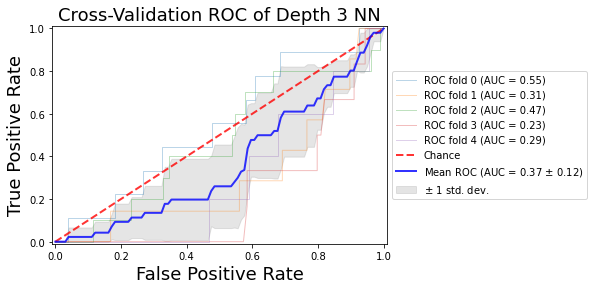

In [11]:
from sklearn.metrics import roc_auc_score
kfold = KFold(n_splits=5, shuffle=True)
inputs = x_d3.copy()
inputs = np.array(inputs)
inputs = np.stack(inputs)
targets = y_d3.copy()
targets = np.array([np.array(xi) for xi in targets])

n_classes = 19

acc_per_fold = []
f1_per_fold = []
time_per_fold = []


acc_per_fold_plut = []
f1_per_fold_plut = []
time_per_fold_plut = []

acc_per_fold_mwpm = []
f1_per_fold_mwpm = []
time_per_fold_mwpm = []


tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
plt.figure(figsize=(10,10))

aucs_classes = {}
for i in mlb_d3.classes_:
    aucs_classes[i] = []
    
fig, ax = plt.subplots()

#for i in range(5):

    # K-fold Cross Validation model evaluation
fold_no = 1
for i, (train, test) in enumerate(kfold.split(inputs, targets)):
    i_train = inputs[train].copy()
    i_test = inputs[test].copy()
    x_test_d3 = i_test[:,:2]
    
    
    inputs_train = i_train[:,3:]
    inputs_test = i_test[:,3:]
    
    
    ####################################################################################################
    #test MWPM decoder for this fold
    #labels = targets[train], features = inputs[train]
    #x_test_d3 = translate_to_graph(testData_d3_MWPM, targets[test], mlb_d3)
    decoding_d3, time_mwpm = do_new_decoding(x_test_d3, 3, .03)
    decoding_d3['combine'] = decoding_d3[[0, 1]].values.tolist()
    decoding_d3['combine'].apply(lambda x: x[0].extend(x[1]))
    decoding_d3 = np.array(decoding_d3[0])

    time_per_fold_mwpm.append(time_mwpm)

    pred_mwpm = mlb_d3.transform(decoding_d3)
    if fold_no < 5:
        acc = partial_accuracy(targets[test], pred_mwpm)
    else:
        acc, contingency_mwpm = partial_accuracy_and_contingency(targets[test], pred_mwpm, mlb_d3)
        
    acc_per_fold_mwpm.append(acc)
    f1_per_fold_mwpm.append(f1_score(targets[test], pred_mwpm, average='micro'))


    #####################################################################################################
    #test the plut decoder for this fold

    lookup_d3 = lookup_decoder(3)

    lookup_d3 = train_plut(lookup_d3, inputs_train, targets[train])

    start = time.time_ns()
    pred_plut_d3 = test_plut(lookup_d3, inputs_test)
    end = time.time_ns() 
    time_per_fold_plut.append((end - start)/ (10 ** 9))
    
    if fold_no < 5:
        acc = partial_accuracy(targets[test], pred_plut_d3)
    else:
        acc, contingency_plut = partial_accuracy_and_contingency(targets[test], pred_plut_d3, mlb_d3)

    acc_per_fold_plut.append(acc)
    f1_per_fold_plut.append(f1_score(targets[test], pred_plut_d3, average='micro'))

    #####################################################################################################
    #Test the NN decoder for this fold

    
    model = compile_FFNN_model_DepthThree(3)
    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    inputs_train = np.asarray(inputs_train).astype('int32')
    inputs_test = np.asarray(inputs_test).astype('int32')

    # Fit data to model

    history = model.fit(
        inputs_train, targets[train],
        validation_split=.2,
        epochs=200,
        verbose=1)

   # Generate generalization metrics
    scores = model.evaluate(inputs_test, targets[test], verbose=0)

    #get the time to predicting test
    start = time.time_ns()
    predictions_d3 = model.predict(inputs_test) #change here
    end = time.time_ns()
    time_per_fold.append((end - start)/ (10 ** 9))

    #threshold based on previous tests with train_test_split in hyperparameter tuning
    pred=predictions_d3.copy() #change here
    pred[pred>=.1]=1 
    pred[pred<.1]=0
    
    if fold_no <5:
        acc = scores[1]
    else:
        acc, contingency_nn = partial_accuracy_and_contingency(targets[test], pred, mlb_d3)

    acc_per_fold.append(acc)
    f1_per_fold.append(f1_score(targets[test], pred, average='micro'))

    #####################################################################################################
    #comput ROC AUC for classes and the mircoaverage
    fpr, tpr, thresholds = roc_curve(targets[test].ravel(), predictions_d3.ravel())
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    #get the AUCs of each class, used to get average AUC of each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(targets[test][:, i], predictions_d3[:, i]) #change here
        aucs_classes[mlb_d3.classes_[i]].append(auc(fpr[i], tpr[i]))
        
    # Increase fold number
    fold_no = fold_no + 1
        
#########################################################################################################
#compute McNemar's statistic on results of last fold

mcnemar_results_mwpm = {}
mcnemar_results_plut = {}

for class_ in mlb_d3.classes_:
    #compute the x^2 for NN and MWPM
    mcnemar_results_mwpm[class_]=contingency_table_and_t(contingency_nn[class_], contingency_mwpm[class_])[1]    
    #comput the x^2 for NN and PLUT
    mcnemar_results_plut[class_] = contingency_table_and_t(contingency_nn[class_], contingency_plut[class_])[1]
        
    
############print mean and stdev of AUC of each class#####################      
    
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('------------------------------------------------------------------------')
print('Average scores for all folds of MWPM:')
print(f'> Accuracy: {np.mean(acc_per_fold_mwpm)} (+- {np.std(acc_per_fold_mwpm)})')
print(f'> F1: {np.mean(f1_per_fold_mwpm)}(+- {np.std(f1_per_fold_mwpm)})')
print(f'> Time: {np.mean(time_per_fold_mwpm)} (+- {np.std(time_per_fold_mwpm)})')
print("#####################################################################################")
print('Average scores for all folds of PLUT:')
print(f'> Accuracy: {np.mean(acc_per_fold_plut)} (+- {np.std(acc_per_fold_plut)})')
print(f'> F1: {np.mean(f1_per_fold_plut)}(+- {np.std(f1_per_fold_plut)})')
print(f'> Time: {np.mean(time_per_fold_plut)} (+- {np.std(time_per_fold_plut)})')
print("#####################################################################################")
print('Average scores for all folds of NN:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> F1: {np.mean(f1_per_fold)}(+- {np.std(f1_per_fold)})')
print(f'> Time: {np.mean(time_per_fold)} (+- {np.std(time_per_fold)})')
print("#####################################################################################")
for key in aucs_classes:
    cleanedList = [x for x in aucs_classes[key] if str(x) != 'nan']
    print(f'> AUC for class {key}: {np.mean(cleanedList)} (+- {np.std(cleanedList)})') #this has to be a for loop
    print("X^2 for MWPM and NN: " + str(mcnemar_results_mwpm[key]))  
    print("X^2 for PLUT and NN: " + str(mcnemar_results_plut[key]))
print("###################################################################################")
print("TOTAL F1 NN: " + str(f1_per_fold))
print("TOTAL F1 PLUT: " + str(f1_per_fold_plut))
print("TOTAL F1 MWPM: " + str(f1_per_fold_mwpm))
print("TOTAL ACC NN: " + str(acc_per_fold))
print("TOTAL ACC PLUT: " + str(acc_per_fold_plut))
print("TOTAL ACC MWPM: " + str(acc_per_fold_mwpm))
print("TOTAL TIME NN: " + str(time_per_fold))
print("TOTAL TIME PLUT: " + str(time_per_fold_plut))
print("TOTAL TIME MWPM: " + str(time_per_fold_mwpm))
print('------------------------------------------------------------------------')


plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate',fontsize=18)
plt.ylabel('True Positive Rate',fontsize=18)
plt.title('Cross-Validation ROC of Depth 3 NN',fontsize=18)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [39]:

plt.rcParams.update({'font.size': 22})

model = compile_FFNN_model_DepthThree(3)
print("Fit model on training data")
history = model.fit(
    x=x_train_d3.values,
    y=Y_train_d3,
    validation_split=.25,
    epochs=200
)

Fit model on training data


NameError: name 'x_train_d3' is not defined

In [45]:
"""
# Make a quick epoch vs. accuracy plot
plt.figure(figsize=(10,10))
plt.grid()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Depth 3 Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')"""

"\n# Make a quick epoch vs. accuracy plot\nplt.figure(figsize=(10,10))\nplt.grid()\nplt.plot(history.history['accuracy'])\nplt.plot(history.history['val_accuracy'])\nplt.title('Depth 3 Model Accuracy')\nplt.xlabel('Epochs')\nplt.ylabel('Accuracy')"

In [46]:
"""
start = time.time()
predictions_d3 = model.predict(x_test_d3.values)
end = time.time()
print("Time: " + str(end - start))
# predict

thresholds=[0.1, .2, .3, .4, .5, .6, .7, .8, .9]
for val in thresholds:
    pred=predictions_d3.copy()
  
    pred[pred>=val]=1
    pred[pred<val]=0

    precision = precision_score(Y_test_d3, pred, average='micro')
    recall = recall_score(Y_test_d3, pred, average='micro')
    f1 = f1_score(Y_test_d3, pred, average='micro')
   
    print("Micro-average quality numbers")
    print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))
    print("Accuracy = ",accuracy_score(Y_test_d3, pred))
    print("Partial Accuracy = ",partial_accuracy(Y_test_d3, pred))
    print("\n")"""

'\nstart = time.time()\npredictions_d3 = model.predict(x_test_d3.values)\nend = time.time()\nprint("Time: " + str(end - start))\n# predict\n\nthresholds=[0.1, .2, .3, .4, .5, .6, .7, .8, .9]\nfor val in thresholds:\n    pred=predictions_d3.copy()\n  \n    pred[pred>=val]=1\n    pred[pred<val]=0\n\n    precision = precision_score(Y_test_d3, pred, average=\'micro\')\n    recall = recall_score(Y_test_d3, pred, average=\'micro\')\n    f1 = f1_score(Y_test_d3, pred, average=\'micro\')\n   \n    print("Micro-average quality numbers")\n    print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))\n    print("Accuracy = ",accuracy_score(Y_test_d3, pred))\n    print("Partial Accuracy = ",partial_accuracy(Y_test_d3, pred))\n    print("\n")'

------------------------------------------------------------------------
Training for fold 6 ...
Epoch 1/800
53/53 [==============================] - 0s 3ms/step - loss: 0.6433 - accuracy: 0.0210 - val_loss: 0.5634 - val_accuracy: 0.0252
Epoch 2/800
53/53 [==============================] - 0s 1ms/step - loss: 0.3369 - accuracy: 0.0216 - val_loss: 0.2582 - val_accuracy: 0.0252
Epoch 3/800
53/53 [==============================] - 0s 1ms/step - loss: 0.1913 - accuracy: 0.0228 - val_loss: 0.2525 - val_accuracy: 0.0198
Epoch 4/800
53/53 [==============================] - 0s 1ms/step - loss: 0.1877 - accuracy: 0.0264 - val_loss: 0.2511 - val_accuracy: 0.0216
Epoch 5/800
53/53 [==============================] - 0s 1ms/step - loss: 0.1868 - accuracy: 0.0240 - val_loss: 0.2498 - val_accuracy: 0.0000e+00
Epoch 6/800
53/53 [==============================] - 0s 1ms/step - loss: 0.1864 - accuracy: 0.0090 - val_loss: 0.2495 - val_accuracy: 0.0000e+00
Epoch 7/800
53/53 [==============================

Epoch 58/800
53/53 [==============================] - 0s 1ms/step - loss: 0.1793 - accuracy: 0.1225 - val_loss: 0.2382 - val_accuracy: 0.1730
Epoch 59/800
53/53 [==============================] - 0s 1ms/step - loss: 0.1791 - accuracy: 0.1297 - val_loss: 0.2381 - val_accuracy: 0.0991
Epoch 60/800
53/53 [==============================] - 0s 1ms/step - loss: 0.1788 - accuracy: 0.1117 - val_loss: 0.2379 - val_accuracy: 0.0505
Epoch 61/800
53/53 [==============================] - 0s 1ms/step - loss: 0.1785 - accuracy: 0.0889 - val_loss: 0.2373 - val_accuracy: 0.1514
Epoch 62/800
53/53 [==============================] - 0s 1ms/step - loss: 0.1782 - accuracy: 0.1141 - val_loss: 0.2376 - val_accuracy: 0.1063
Epoch 63/800
53/53 [==============================] - 0s 1ms/step - loss: 0.1779 - accuracy: 0.1225 - val_loss: 0.2367 - val_accuracy: 0.1117
Epoch 64/800
53/53 [==============================] - 0s 1ms/step - loss: 0.1776 - accuracy: 0.1333 - val_loss: 0.2360 - val_accuracy: 0.1099
Epoch 

53/53 [==============================] - 0s 1ms/step - loss: 0.1232 - accuracy: 0.2517 - val_loss: 0.1639 - val_accuracy: 0.3261
Epoch 173/800
53/53 [==============================] - 0s 1ms/step - loss: 0.1230 - accuracy: 0.2505 - val_loss: 0.1655 - val_accuracy: 0.3153
Epoch 174/800
53/53 [==============================] - 0s 1ms/step - loss: 0.1224 - accuracy: 0.2625 - val_loss: 0.1642 - val_accuracy: 0.3171
Epoch 175/800
53/53 [==============================] - 0s 1ms/step - loss: 0.1220 - accuracy: 0.2547 - val_loss: 0.1622 - val_accuracy: 0.3099
Epoch 176/800
53/53 [==============================] - 0s 1ms/step - loss: 0.1216 - accuracy: 0.2553 - val_loss: 0.1617 - val_accuracy: 0.3135
Epoch 177/800
53/53 [==============================] - 0s 1ms/step - loss: 0.1212 - accuracy: 0.2583 - val_loss: 0.1623 - val_accuracy: 0.3045
Epoch 178/800
53/53 [==============================] - 0s 1ms/step - loss: 0.1209 - accuracy: 0.2583 - val_loss: 0.1614 - val_accuracy: 0.3207
Epoch 179/800

53/53 [==============================] - 0s 1ms/step - loss: 0.0928 - accuracy: 0.3009 - val_loss: 0.1360 - val_accuracy: 0.3982
Epoch 287/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0926 - accuracy: 0.3105 - val_loss: 0.1342 - val_accuracy: 0.3856
Epoch 288/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0922 - accuracy: 0.3027 - val_loss: 0.1353 - val_accuracy: 0.3495
Epoch 289/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0921 - accuracy: 0.3009 - val_loss: 0.1351 - val_accuracy: 0.3477
Epoch 290/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0920 - accuracy: 0.3111 - val_loss: 0.1341 - val_accuracy: 0.3748
Epoch 291/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0918 - accuracy: 0.3015 - val_loss: 0.1353 - val_accuracy: 0.3802
Epoch 292/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0917 - accuracy: 0.2997 - val_loss: 0.1388 - val_accuracy: 0.3730
Epoch 293/800

53/53 [==============================] - 0s 1ms/step - loss: 0.0797 - accuracy: 0.3285 - val_loss: 0.1252 - val_accuracy: 0.3838
Epoch 401/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0793 - accuracy: 0.3279 - val_loss: 0.1264 - val_accuracy: 0.3946
Epoch 402/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0793 - accuracy: 0.3213 - val_loss: 0.1261 - val_accuracy: 0.3802
Epoch 403/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0793 - accuracy: 0.3339 - val_loss: 0.1272 - val_accuracy: 0.4018
Epoch 404/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0793 - accuracy: 0.3243 - val_loss: 0.1253 - val_accuracy: 0.3477
Epoch 405/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0792 - accuracy: 0.3285 - val_loss: 0.1242 - val_accuracy: 0.3964
Epoch 406/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0789 - accuracy: 0.3249 - val_loss: 0.1247 - val_accuracy: 0.4036
Epoch 407/800

53/53 [==============================] - 0s 2ms/step - loss: 0.0716 - accuracy: 0.3285 - val_loss: 0.1198 - val_accuracy: 0.4108
Epoch 515/800
53/53 [==============================] - 0s 2ms/step - loss: 0.0708 - accuracy: 0.3273 - val_loss: 0.1171 - val_accuracy: 0.3838
Epoch 516/800
53/53 [==============================] - 0s 2ms/step - loss: 0.0707 - accuracy: 0.3285 - val_loss: 0.1411 - val_accuracy: 0.3207
Epoch 517/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0722 - accuracy: 0.3309 - val_loss: 0.1165 - val_accuracy: 0.3874
Epoch 518/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0704 - accuracy: 0.3303 - val_loss: 0.1172 - val_accuracy: 0.3802
Epoch 519/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0704 - accuracy: 0.3267 - val_loss: 0.1185 - val_accuracy: 0.4234
Epoch 520/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0705 - accuracy: 0.3417 - val_loss: 0.1161 - val_accuracy: 0.3928
Epoch 521/800

53/53 [==============================] - 0s 1ms/step - loss: 0.0645 - accuracy: 0.3399 - val_loss: 0.1162 - val_accuracy: 0.4252
Epoch 629/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0642 - accuracy: 0.3393 - val_loss: 0.1238 - val_accuracy: 0.3604
Epoch 630/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0650 - accuracy: 0.3429 - val_loss: 0.1138 - val_accuracy: 0.3820
Epoch 631/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0643 - accuracy: 0.3321 - val_loss: 0.1129 - val_accuracy: 0.3928
Epoch 632/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0642 - accuracy: 0.3327 - val_loss: 0.1100 - val_accuracy: 0.3568
Epoch 633/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0641 - accuracy: 0.3453 - val_loss: 0.1118 - val_accuracy: 0.4036
Epoch 634/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0640 - accuracy: 0.3339 - val_loss: 0.1113 - val_accuracy: 0.3766
Epoch 635/800

53/53 [==============================] - 0s 1ms/step - loss: 0.0590 - accuracy: 0.3447 - val_loss: 0.1106 - val_accuracy: 0.3982
Epoch 743/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0592 - accuracy: 0.3315 - val_loss: 0.1134 - val_accuracy: 0.4054
Epoch 744/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0593 - accuracy: 0.3429 - val_loss: 0.1127 - val_accuracy: 0.4144
Epoch 745/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0591 - accuracy: 0.3417 - val_loss: 0.1666 - val_accuracy: 0.2613
Epoch 746/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0612 - accuracy: 0.3315 - val_loss: 0.1081 - val_accuracy: 0.3964
Epoch 747/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0589 - accuracy: 0.3411 - val_loss: 0.1116 - val_accuracy: 0.3568
Epoch 748/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0595 - accuracy: 0.3285 - val_loss: 0.1091 - val_accuracy: 0.4072
Epoch 749/800

<ipython-input-12-5f8a8e11cd4a>:128: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
C:\Users\Bensom2\miniconda3\envs\my_qiskit\lib\site-packages\sklearn\metrics\_ranking.py:949: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "


------------------------------------------------------------------------
Training for fold 7 ...
Epoch 1/800
53/53 [==============================] - 0s 3ms/step - loss: 0.6229 - accuracy: 0.0024 - val_loss: 0.5201 - val_accuracy: 0.0000e+00
Epoch 2/800
53/53 [==============================] - 0s 1ms/step - loss: 0.2973 - accuracy: 0.0024 - val_loss: 0.2542 - val_accuracy: 0.0414
Epoch 3/800
53/53 [==============================] - 0s 1ms/step - loss: 0.1917 - accuracy: 0.0342 - val_loss: 0.2502 - val_accuracy: 0.0000e+00
Epoch 4/800
53/53 [==============================] - 0s 1ms/step - loss: 0.1881 - accuracy: 0.0108 - val_loss: 0.2493 - val_accuracy: 0.0108
Epoch 5/800
53/53 [==============================] - 0s 1ms/step - loss: 0.1872 - accuracy: 0.0138 - val_loss: 0.2498 - val_accuracy: 0.0216
Epoch 6/800
53/53 [==============================] - 0s 1ms/step - loss: 0.1868 - accuracy: 0.0180 - val_loss: 0.2490 - val_accuracy: 0.0773
Epoch 7/800
53/53 [==============================

Epoch 58/800
53/53 [==============================] - 0s 1ms/step - loss: 0.1813 - accuracy: 0.0781 - val_loss: 0.2424 - val_accuracy: 0.0594
Epoch 59/800
53/53 [==============================] - 0s 1ms/step - loss: 0.1811 - accuracy: 0.0697 - val_loss: 0.2418 - val_accuracy: 0.0018
Epoch 60/800
53/53 [==============================] - 0s 1ms/step - loss: 0.1809 - accuracy: 0.0577 - val_loss: 0.2416 - val_accuracy: 0.0899
Epoch 61/800
53/53 [==============================] - 0s 1ms/step - loss: 0.1807 - accuracy: 0.0937 - val_loss: 0.2416 - val_accuracy: 0.0540
Epoch 62/800
53/53 [==============================] - 0s 1ms/step - loss: 0.1804 - accuracy: 0.0721 - val_loss: 0.2409 - val_accuracy: 0.0540
Epoch 63/800
53/53 [==============================] - 0s 1ms/step - loss: 0.1802 - accuracy: 0.0715 - val_loss: 0.2408 - val_accuracy: 0.0629
Epoch 64/800
53/53 [==============================] - 0s 1ms/step - loss: 0.1800 - accuracy: 0.0877 - val_loss: 0.2408 - val_accuracy: 0.0773
Epoch 

53/53 [==============================] - 0s 1ms/step - loss: 0.1278 - accuracy: 0.2396 - val_loss: 0.1750 - val_accuracy: 0.2716
Epoch 173/800
53/53 [==============================] - 0s 1ms/step - loss: 0.1273 - accuracy: 0.2396 - val_loss: 0.1762 - val_accuracy: 0.2374
Epoch 174/800
53/53 [==============================] - 0s 1ms/step - loss: 0.1271 - accuracy: 0.2312 - val_loss: 0.1739 - val_accuracy: 0.2896
Epoch 175/800
53/53 [==============================] - 0s 1ms/step - loss: 0.1266 - accuracy: 0.2396 - val_loss: 0.1731 - val_accuracy: 0.2536
Epoch 176/800
53/53 [==============================] - 0s 1ms/step - loss: 0.1262 - accuracy: 0.2414 - val_loss: 0.1733 - val_accuracy: 0.2896
Epoch 177/800
53/53 [==============================] - 0s 1ms/step - loss: 0.1258 - accuracy: 0.2408 - val_loss: 0.1738 - val_accuracy: 0.2662
Epoch 178/800
53/53 [==============================] - 0s 1ms/step - loss: 0.1255 - accuracy: 0.2432 - val_loss: 0.1734 - val_accuracy: 0.2608
Epoch 179/800

53/53 [==============================] - 0s 1ms/step - loss: 0.0986 - accuracy: 0.2871 - val_loss: 0.1449 - val_accuracy: 0.3112
Epoch 287/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0985 - accuracy: 0.2823 - val_loss: 0.1450 - val_accuracy: 0.3489
Epoch 288/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0984 - accuracy: 0.2949 - val_loss: 0.1451 - val_accuracy: 0.3489
Epoch 289/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0982 - accuracy: 0.2979 - val_loss: 0.1447 - val_accuracy: 0.3291
Epoch 290/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0983 - accuracy: 0.2961 - val_loss: 0.1573 - val_accuracy: 0.2950
Epoch 291/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0988 - accuracy: 0.2883 - val_loss: 0.1443 - val_accuracy: 0.3417
Epoch 292/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0978 - accuracy: 0.2931 - val_loss: 0.1437 - val_accuracy: 0.3076
Epoch 293/800

53/53 [==============================] - 0s 1ms/step - loss: 0.0852 - accuracy: 0.3135 - val_loss: 0.1336 - val_accuracy: 0.3273
Epoch 401/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0851 - accuracy: 0.3087 - val_loss: 0.1352 - val_accuracy: 0.3058
Epoch 402/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0851 - accuracy: 0.2997 - val_loss: 0.1346 - val_accuracy: 0.3273
Epoch 403/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0849 - accuracy: 0.3057 - val_loss: 0.1342 - val_accuracy: 0.2662
Epoch 404/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0848 - accuracy: 0.3021 - val_loss: 0.1336 - val_accuracy: 0.3094
Epoch 405/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0848 - accuracy: 0.3057 - val_loss: 0.1559 - val_accuracy: 0.2356
Epoch 406/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0858 - accuracy: 0.3057 - val_loss: 0.1335 - val_accuracy: 0.3147
Epoch 407/800

53/53 [==============================] - 0s 1ms/step - loss: 0.0760 - accuracy: 0.3087 - val_loss: 0.1285 - val_accuracy: 0.2860
Epoch 515/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0756 - accuracy: 0.3063 - val_loss: 0.1294 - val_accuracy: 0.2824
Epoch 516/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0757 - accuracy: 0.3087 - val_loss: 0.1300 - val_accuracy: 0.2716
Epoch 517/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0757 - accuracy: 0.3087 - val_loss: 0.1295 - val_accuracy: 0.3058
Epoch 518/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0756 - accuracy: 0.3129 - val_loss: 0.1294 - val_accuracy: 0.2878
Epoch 519/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0755 - accuracy: 0.3057 - val_loss: 0.1286 - val_accuracy: 0.2770
Epoch 520/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0755 - accuracy: 0.3045 - val_loss: 0.1297 - val_accuracy: 0.2932
Epoch 521/800

53/53 [==============================] - 0s 1ms/step - loss: 0.0684 - accuracy: 0.3231 - val_loss: 0.1242 - val_accuracy: 0.2770
Epoch 629/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0683 - accuracy: 0.3225 - val_loss: 0.1244 - val_accuracy: 0.2842
Epoch 630/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0682 - accuracy: 0.3135 - val_loss: 0.1272 - val_accuracy: 0.3040
Epoch 631/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0681 - accuracy: 0.3243 - val_loss: 0.1250 - val_accuracy: 0.2770
Epoch 632/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0681 - accuracy: 0.3195 - val_loss: 0.1240 - val_accuracy: 0.3112
Epoch 633/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0681 - accuracy: 0.3099 - val_loss: 0.1250 - val_accuracy: 0.2950
Epoch 634/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0680 - accuracy: 0.3225 - val_loss: 0.1482 - val_accuracy: 0.1960
Epoch 635/800

53/53 [==============================] - 0s 1ms/step - loss: 0.0624 - accuracy: 0.3129 - val_loss: 0.1207 - val_accuracy: 0.3129
Epoch 743/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0621 - accuracy: 0.3087 - val_loss: 0.1233 - val_accuracy: 0.3076
Epoch 744/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0622 - accuracy: 0.3165 - val_loss: 0.1241 - val_accuracy: 0.3058
Epoch 745/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0624 - accuracy: 0.3099 - val_loss: 0.1222 - val_accuracy: 0.3076
Epoch 746/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0620 - accuracy: 0.3141 - val_loss: 0.1218 - val_accuracy: 0.3147
Epoch 747/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0621 - accuracy: 0.3129 - val_loss: 0.1221 - val_accuracy: 0.2950
Epoch 748/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0619 - accuracy: 0.3147 - val_loss: 0.1260 - val_accuracy: 0.3112
Epoch 749/800

<ipython-input-12-5f8a8e11cd4a>:128: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


------------------------------------------------------------------------
Training for fold 8 ...
Epoch 1/800
53/53 [==============================] - 0s 3ms/step - loss: 0.6415 - accuracy: 0.0348 - val_loss: 0.5646 - val_accuracy: 0.0558
Epoch 2/800
53/53 [==============================] - 0s 1ms/step - loss: 0.3396 - accuracy: 0.0408 - val_loss: 0.2600 - val_accuracy: 0.0558
Epoch 3/800
53/53 [==============================] - 0s 1ms/step - loss: 0.1913 - accuracy: 0.0348 - val_loss: 0.2525 - val_accuracy: 0.0126
Epoch 4/800
53/53 [==============================] - 0s 1ms/step - loss: 0.1874 - accuracy: 0.0192 - val_loss: 0.2514 - val_accuracy: 0.0000e+00
Epoch 5/800
53/53 [==============================] - 0s 1ms/step - loss: 0.1867 - accuracy: 0.0126 - val_loss: 0.2506 - val_accuracy: 0.0234
Epoch 6/800
53/53 [==============================] - 0s 1ms/step - loss: 0.1865 - accuracy: 0.0144 - val_loss: 0.2506 - val_accuracy: 0.0000e+00
Epoch 7/800
53/53 [==============================

Epoch 58/800
53/53 [==============================] - 0s 1ms/step - loss: 0.1822 - accuracy: 0.0961 - val_loss: 0.2430 - val_accuracy: 0.0827
Epoch 59/800
53/53 [==============================] - 0s 1ms/step - loss: 0.1821 - accuracy: 0.0955 - val_loss: 0.2425 - val_accuracy: 0.0827
Epoch 60/800
53/53 [==============================] - 0s 1ms/step - loss: 0.1819 - accuracy: 0.0925 - val_loss: 0.2429 - val_accuracy: 0.0036
Epoch 61/800
53/53 [==============================] - 0s 1ms/step - loss: 0.1818 - accuracy: 0.0312 - val_loss: 0.2422 - val_accuracy: 0.0234
Epoch 62/800
53/53 [==============================] - 0s 1ms/step - loss: 0.1816 - accuracy: 0.0631 - val_loss: 0.2420 - val_accuracy: 0.0000e+00
Epoch 63/800
53/53 [==============================] - 0s 1ms/step - loss: 0.1815 - accuracy: 0.0619 - val_loss: 0.2420 - val_accuracy: 0.0791
Epoch 64/800
53/53 [==============================] - 0s 1ms/step - loss: 0.1813 - accuracy: 0.0739 - val_loss: 0.2418 - val_accuracy: 0.0576
Ep

53/53 [==============================] - 0s 1ms/step - loss: 0.1320 - accuracy: 0.2198 - val_loss: 0.1765 - val_accuracy: 0.2266
Epoch 173/800
53/53 [==============================] - 0s 1ms/step - loss: 0.1317 - accuracy: 0.2252 - val_loss: 0.1735 - val_accuracy: 0.2608
Epoch 174/800
53/53 [==============================] - 0s 1ms/step - loss: 0.1312 - accuracy: 0.2234 - val_loss: 0.1766 - val_accuracy: 0.2464
Epoch 175/800
53/53 [==============================] - 0s 1ms/step - loss: 0.1310 - accuracy: 0.2222 - val_loss: 0.1724 - val_accuracy: 0.2320
Epoch 176/800
53/53 [==============================] - 0s 1ms/step - loss: 0.1304 - accuracy: 0.2300 - val_loss: 0.1719 - val_accuracy: 0.2284
Epoch 177/800
53/53 [==============================] - 0s 1ms/step - loss: 0.1301 - accuracy: 0.2168 - val_loss: 0.1711 - val_accuracy: 0.2554
Epoch 178/800
53/53 [==============================] - 0s 1ms/step - loss: 0.1297 - accuracy: 0.2360 - val_loss: 0.1708 - val_accuracy: 0.2428
Epoch 179/800

53/53 [==============================] - 0s 1ms/step - loss: 0.1025 - accuracy: 0.2781 - val_loss: 0.1455 - val_accuracy: 0.3040
Epoch 287/800
53/53 [==============================] - 0s 1ms/step - loss: 0.1023 - accuracy: 0.2751 - val_loss: 0.1443 - val_accuracy: 0.2644
Epoch 288/800
53/53 [==============================] - 0s 1ms/step - loss: 0.1021 - accuracy: 0.2679 - val_loss: 0.1471 - val_accuracy: 0.2806
Epoch 289/800
53/53 [==============================] - 0s 1ms/step - loss: 0.1021 - accuracy: 0.2715 - val_loss: 0.1463 - val_accuracy: 0.2770
Epoch 290/800
53/53 [==============================] - 0s 1ms/step - loss: 0.1018 - accuracy: 0.2709 - val_loss: 0.1461 - val_accuracy: 0.3076
Epoch 291/800
53/53 [==============================] - 0s 1ms/step - loss: 0.1016 - accuracy: 0.2775 - val_loss: 0.1457 - val_accuracy: 0.2788
Epoch 292/800
53/53 [==============================] - 0s 1ms/step - loss: 0.1014 - accuracy: 0.2763 - val_loss: 0.1455 - val_accuracy: 0.2824
Epoch 293/800

53/53 [==============================] - 0s 1ms/step - loss: 0.0879 - accuracy: 0.3033 - val_loss: 0.1366 - val_accuracy: 0.3255
Epoch 401/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0879 - accuracy: 0.3075 - val_loss: 0.1366 - val_accuracy: 0.3129
Epoch 402/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0877 - accuracy: 0.3123 - val_loss: 0.1362 - val_accuracy: 0.3219
Epoch 403/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0877 - accuracy: 0.3087 - val_loss: 0.1369 - val_accuracy: 0.3147
Epoch 404/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0875 - accuracy: 0.3099 - val_loss: 0.1351 - val_accuracy: 0.3255
Epoch 405/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0875 - accuracy: 0.3141 - val_loss: 0.1355 - val_accuracy: 0.2770
Epoch 406/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0874 - accuracy: 0.3153 - val_loss: 0.1358 - val_accuracy: 0.3112
Epoch 407/800

53/53 [==============================] - 0s 1ms/step - loss: 0.0791 - accuracy: 0.3243 - val_loss: 0.1309 - val_accuracy: 0.3219
Epoch 515/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0789 - accuracy: 0.3267 - val_loss: 0.1324 - val_accuracy: 0.3058
Epoch 516/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0789 - accuracy: 0.3297 - val_loss: 0.1311 - val_accuracy: 0.3112
Epoch 517/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0789 - accuracy: 0.3219 - val_loss: 0.1304 - val_accuracy: 0.3273
Epoch 518/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0788 - accuracy: 0.3243 - val_loss: 0.1333 - val_accuracy: 0.3040
Epoch 519/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0789 - accuracy: 0.3129 - val_loss: 0.1310 - val_accuracy: 0.3273
Epoch 520/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0786 - accuracy: 0.3279 - val_loss: 0.1307 - val_accuracy: 0.3417
Epoch 521/800

53/53 [==============================] - 0s 1ms/step - loss: 0.0723 - accuracy: 0.3297 - val_loss: 0.1259 - val_accuracy: 0.3291
Epoch 629/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0723 - accuracy: 0.3321 - val_loss: 0.1274 - val_accuracy: 0.3399
Epoch 630/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0724 - accuracy: 0.3309 - val_loss: 0.1291 - val_accuracy: 0.3471
Epoch 631/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0721 - accuracy: 0.3285 - val_loss: 0.1248 - val_accuracy: 0.3076
Epoch 632/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0721 - accuracy: 0.3213 - val_loss: 0.1349 - val_accuracy: 0.3453
Epoch 633/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0725 - accuracy: 0.3345 - val_loss: 0.1283 - val_accuracy: 0.3255
Epoch 634/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0719 - accuracy: 0.3243 - val_loss: 0.1269 - val_accuracy: 0.3363
Epoch 635/800

53/53 [==============================] - 0s 1ms/step - loss: 0.0670 - accuracy: 0.3333 - val_loss: 0.1233 - val_accuracy: 0.3381
Epoch 743/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0666 - accuracy: 0.3261 - val_loss: 0.1235 - val_accuracy: 0.3255
Epoch 744/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0666 - accuracy: 0.3273 - val_loss: 0.1216 - val_accuracy: 0.3094
Epoch 745/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0667 - accuracy: 0.3357 - val_loss: 0.1255 - val_accuracy: 0.3309
Epoch 746/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0667 - accuracy: 0.3345 - val_loss: 0.1264 - val_accuracy: 0.3040
Epoch 747/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0667 - accuracy: 0.3327 - val_loss: 0.1261 - val_accuracy: 0.3022
Epoch 748/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0666 - accuracy: 0.3423 - val_loss: 0.1231 - val_accuracy: 0.3112
Epoch 749/800

<ipython-input-12-5f8a8e11cd4a>:128: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
C:\Users\Bensom2\miniconda3\envs\my_qiskit\lib\site-packages\sklearn\metrics\_ranking.py:949: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "


------------------------------------------------------------------------
Training for fold 9 ...
Epoch 1/800
53/53 [==============================] - 0s 3ms/step - loss: 0.6570 - accuracy: 0.0054 - val_loss: 0.6139 - val_accuracy: 0.0000e+00
Epoch 2/800
53/53 [==============================] - 0s 1ms/step - loss: 0.4327 - accuracy: 0.0060 - val_loss: 0.2712 - val_accuracy: 0.0072
Epoch 3/800
53/53 [==============================] - 0s 1ms/step - loss: 0.1952 - accuracy: 0.0246 - val_loss: 0.2531 - val_accuracy: 0.0000e+00
Epoch 4/800
53/53 [==============================] - 0s 1ms/step - loss: 0.1886 - accuracy: 0.0186 - val_loss: 0.2519 - val_accuracy: 0.0450
Epoch 5/800
53/53 [==============================] - 0s 1ms/step - loss: 0.1877 - accuracy: 0.0402 - val_loss: 0.2522 - val_accuracy: 0.0000e+00
Epoch 6/800
53/53 [==============================] - 0s 1ms/step - loss: 0.1874 - accuracy: 0.0138 - val_loss: 0.2520 - val_accuracy: 0.0324
Epoch 7/800
53/53 [==========================

Epoch 58/800
53/53 [==============================] - 0s 1ms/step - loss: 0.1816 - accuracy: 0.0733 - val_loss: 0.2429 - val_accuracy: 0.0809
Epoch 59/800
53/53 [==============================] - 0s 1ms/step - loss: 0.1815 - accuracy: 0.0793 - val_loss: 0.2424 - val_accuracy: 0.0881
Epoch 60/800
53/53 [==============================] - 0s 1ms/step - loss: 0.1813 - accuracy: 0.0823 - val_loss: 0.2429 - val_accuracy: 0.0737
Epoch 61/800
53/53 [==============================] - 0s 1ms/step - loss: 0.1811 - accuracy: 0.0739 - val_loss: 0.2421 - val_accuracy: 0.0234
Epoch 62/800
53/53 [==============================] - 0s 1ms/step - loss: 0.1809 - accuracy: 0.0805 - val_loss: 0.2420 - val_accuracy: 0.0234
Epoch 63/800
53/53 [==============================] - 0s 1ms/step - loss: 0.1807 - accuracy: 0.0751 - val_loss: 0.2416 - val_accuracy: 0.0252
Epoch 64/800
53/53 [==============================] - 0s 1ms/step - loss: 0.1805 - accuracy: 0.0517 - val_loss: 0.2411 - val_accuracy: 0.1133
Epoch 

53/53 [==============================] - 0s 1ms/step - loss: 0.1354 - accuracy: 0.2078 - val_loss: 0.1830 - val_accuracy: 0.2320
Epoch 173/800
53/53 [==============================] - 0s 1ms/step - loss: 0.1349 - accuracy: 0.2036 - val_loss: 0.1821 - val_accuracy: 0.2176
Epoch 174/800
53/53 [==============================] - 0s 1ms/step - loss: 0.1346 - accuracy: 0.2048 - val_loss: 0.1854 - val_accuracy: 0.2302
Epoch 175/800
53/53 [==============================] - 0s 1ms/step - loss: 0.1344 - accuracy: 0.2168 - val_loss: 0.1816 - val_accuracy: 0.2392
Epoch 176/800
53/53 [==============================] - 0s 1ms/step - loss: 0.1341 - accuracy: 0.2114 - val_loss: 0.1823 - val_accuracy: 0.2266
Epoch 177/800
53/53 [==============================] - 0s 1ms/step - loss: 0.1337 - accuracy: 0.2162 - val_loss: 0.1811 - val_accuracy: 0.2266
Epoch 178/800
53/53 [==============================] - 0s 1ms/step - loss: 0.1335 - accuracy: 0.2120 - val_loss: 0.1801 - val_accuracy: 0.2284
Epoch 179/800

53/53 [==============================] - 0s 1ms/step - loss: 0.1053 - accuracy: 0.2781 - val_loss: 0.1463 - val_accuracy: 0.3094
Epoch 287/800
53/53 [==============================] - 0s 1ms/step - loss: 0.1051 - accuracy: 0.2733 - val_loss: 0.1475 - val_accuracy: 0.2842
Epoch 288/800
53/53 [==============================] - 0s 1ms/step - loss: 0.1049 - accuracy: 0.2793 - val_loss: 0.1488 - val_accuracy: 0.2824
Epoch 289/800
53/53 [==============================] - 0s 1ms/step - loss: 0.1048 - accuracy: 0.2799 - val_loss: 0.1478 - val_accuracy: 0.3094
Epoch 290/800
53/53 [==============================] - 0s 1ms/step - loss: 0.1045 - accuracy: 0.2817 - val_loss: 0.1477 - val_accuracy: 0.2932
Epoch 291/800
53/53 [==============================] - 0s 1ms/step - loss: 0.1043 - accuracy: 0.2757 - val_loss: 0.1457 - val_accuracy: 0.2932
Epoch 292/800
53/53 [==============================] - 0s 1ms/step - loss: 0.1039 - accuracy: 0.2715 - val_loss: 0.1510 - val_accuracy: 0.2230
Epoch 293/800

53/53 [==============================] - 0s 1ms/step - loss: 0.0861 - accuracy: 0.3045 - val_loss: 0.1290 - val_accuracy: 0.3040
Epoch 401/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0856 - accuracy: 0.3135 - val_loss: 0.1408 - val_accuracy: 0.2770
Epoch 402/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0864 - accuracy: 0.3165 - val_loss: 0.1416 - val_accuracy: 0.3147
Epoch 403/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0861 - accuracy: 0.3195 - val_loss: 0.1302 - val_accuracy: 0.2536
Epoch 404/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0857 - accuracy: 0.3045 - val_loss: 0.1294 - val_accuracy: 0.3058
Epoch 405/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0851 - accuracy: 0.3207 - val_loss: 0.1287 - val_accuracy: 0.2896
Epoch 406/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0853 - accuracy: 0.3075 - val_loss: 0.1277 - val_accuracy: 0.3040
Epoch 407/800

53/53 [==============================] - 0s 1ms/step - loss: 0.0753 - accuracy: 0.3183 - val_loss: 0.1193 - val_accuracy: 0.2950
Epoch 515/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0754 - accuracy: 0.3123 - val_loss: 0.1214 - val_accuracy: 0.3237
Epoch 516/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0751 - accuracy: 0.3183 - val_loss: 0.1247 - val_accuracy: 0.3165
Epoch 517/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0754 - accuracy: 0.3207 - val_loss: 0.1186 - val_accuracy: 0.3129
Epoch 518/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0751 - accuracy: 0.3165 - val_loss: 0.1409 - val_accuracy: 0.2158
Epoch 519/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0765 - accuracy: 0.3183 - val_loss: 0.1231 - val_accuracy: 0.3147
Epoch 520/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0751 - accuracy: 0.3153 - val_loss: 0.1210 - val_accuracy: 0.3237
Epoch 521/800

53/53 [==============================] - 0s 1ms/step - loss: 0.0692 - accuracy: 0.3213 - val_loss: 0.1161 - val_accuracy: 0.3417
Epoch 629/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0687 - accuracy: 0.3351 - val_loss: 0.1153 - val_accuracy: 0.3094
Epoch 630/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0685 - accuracy: 0.3255 - val_loss: 0.1167 - val_accuracy: 0.3273
Epoch 631/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0684 - accuracy: 0.3207 - val_loss: 0.1247 - val_accuracy: 0.2950
Epoch 632/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0690 - accuracy: 0.3285 - val_loss: 0.1326 - val_accuracy: 0.2194
Epoch 633/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0696 - accuracy: 0.3045 - val_loss: 0.1149 - val_accuracy: 0.3004
Epoch 634/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0684 - accuracy: 0.3219 - val_loss: 0.1168 - val_accuracy: 0.3381
Epoch 635/800

53/53 [==============================] - 0s 1ms/step - loss: 0.0638 - accuracy: 0.3135 - val_loss: 0.1106 - val_accuracy: 0.3183
Epoch 743/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0630 - accuracy: 0.3315 - val_loss: 0.1116 - val_accuracy: 0.3381
Epoch 744/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0631 - accuracy: 0.3267 - val_loss: 0.1126 - val_accuracy: 0.3291
Epoch 745/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0631 - accuracy: 0.3339 - val_loss: 0.1243 - val_accuracy: 0.3381
Epoch 746/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0639 - accuracy: 0.3321 - val_loss: 0.1296 - val_accuracy: 0.3525
Epoch 747/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0644 - accuracy: 0.3291 - val_loss: 0.1147 - val_accuracy: 0.3183
Epoch 748/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0631 - accuracy: 0.3219 - val_loss: 0.1108 - val_accuracy: 0.3273
Epoch 749/800

<ipython-input-12-5f8a8e11cd4a>:128: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
C:\Users\Bensom2\miniconda3\envs\my_qiskit\lib\site-packages\sklearn\metrics\_ranking.py:949: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "


------------------------------------------------------------------------
Training for fold 10 ...
Epoch 1/800
53/53 [==============================] - 1s 3ms/step - loss: 0.6689 - accuracy: 0.0192 - val_loss: 0.6359 - val_accuracy: 0.0252
Epoch 2/800
53/53 [==============================] - 0s 2ms/step - loss: 0.5076 - accuracy: 0.0132 - val_loss: 0.3305 - val_accuracy: 0.0360
Epoch 3/800
53/53 [==============================] - 0s 2ms/step - loss: 0.2098 - accuracy: 0.0288 - val_loss: 0.2547 - val_accuracy: 0.0432
Epoch 4/800
53/53 [==============================] - 0s 2ms/step - loss: 0.1892 - accuracy: 0.0438 - val_loss: 0.2516 - val_accuracy: 0.0737
Epoch 5/800
53/53 [==============================] - 0s 2ms/step - loss: 0.1876 - accuracy: 0.0535 - val_loss: 0.2507 - val_accuracy: 0.0432
Epoch 6/800
53/53 [==============================] - 0s 2ms/step - loss: 0.1872 - accuracy: 0.0505 - val_loss: 0.2500 - val_accuracy: 0.0000e+00
Epoch 7/800
53/53 [==============================] -

53/53 [==============================] - 0s 1ms/step - loss: 0.1825 - accuracy: 0.0823 - val_loss: 0.2438 - val_accuracy: 0.0827
Epoch 59/800
53/53 [==============================] - 0s 2ms/step - loss: 0.1824 - accuracy: 0.1027 - val_loss: 0.2433 - val_accuracy: 0.0899
Epoch 60/800
53/53 [==============================] - 0s 1ms/step - loss: 0.1822 - accuracy: 0.1099 - val_loss: 0.2436 - val_accuracy: 0.0234
Epoch 61/800
53/53 [==============================] - 0s 1ms/step - loss: 0.1821 - accuracy: 0.1009 - val_loss: 0.2434 - val_accuracy: 0.0863
Epoch 62/800
53/53 [==============================] - 0s 2ms/step - loss: 0.1819 - accuracy: 0.1075 - val_loss: 0.2433 - val_accuracy: 0.0468
Epoch 63/800
53/53 [==============================] - 0s 1ms/step - loss: 0.1817 - accuracy: 0.0823 - val_loss: 0.2427 - val_accuracy: 0.1115
Epoch 64/800
53/53 [==============================] - 0s 1ms/step - loss: 0.1816 - accuracy: 0.1195 - val_loss: 0.2425 - val_accuracy: 0.0701
Epoch 65/800
53/53 

Epoch 116/800
53/53 [==============================] - 0s 2ms/step - loss: 0.1592 - accuracy: 0.2072 - val_loss: 0.2122 - val_accuracy: 0.2248
Epoch 117/800
53/53 [==============================] - 0s 2ms/step - loss: 0.1585 - accuracy: 0.2324 - val_loss: 0.2119 - val_accuracy: 0.1888
Epoch 118/800
53/53 [==============================] - 0s 2ms/step - loss: 0.1579 - accuracy: 0.2138 - val_loss: 0.2112 - val_accuracy: 0.2194
Epoch 119/800
53/53 [==============================] - 0s 2ms/step - loss: 0.1572 - accuracy: 0.2270 - val_loss: 0.2100 - val_accuracy: 0.2212
Epoch 120/800
53/53 [==============================] - 0s 2ms/step - loss: 0.1566 - accuracy: 0.2258 - val_loss: 0.2097 - val_accuracy: 0.2050
Epoch 121/800
53/53 [==============================] - 0s 2ms/step - loss: 0.1559 - accuracy: 0.2126 - val_loss: 0.2083 - val_accuracy: 0.2158
Epoch 122/800
53/53 [==============================] - 0s 2ms/step - loss: 0.1553 - accuracy: 0.2162 - val_loss: 0.2080 - val_accuracy: 0.2014

53/53 [==============================] - 0s 1ms/step - loss: 0.1121 - accuracy: 0.3219 - val_loss: 0.1594 - val_accuracy: 0.3417
Epoch 231/800
53/53 [==============================] - 0s 1ms/step - loss: 0.1119 - accuracy: 0.3291 - val_loss: 0.1646 - val_accuracy: 0.3147
Epoch 232/800
53/53 [==============================] - 0s 1ms/step - loss: 0.1121 - accuracy: 0.3177 - val_loss: 0.1588 - val_accuracy: 0.3255
Epoch 233/800
53/53 [==============================] - 0s 1ms/step - loss: 0.1116 - accuracy: 0.3189 - val_loss: 0.1587 - val_accuracy: 0.3507
Epoch 234/800
53/53 [==============================] - 0s 1ms/step - loss: 0.1114 - accuracy: 0.3135 - val_loss: 0.1593 - val_accuracy: 0.3129
Epoch 235/800
53/53 [==============================] - 0s 1ms/step - loss: 0.1113 - accuracy: 0.3255 - val_loss: 0.1580 - val_accuracy: 0.3327
Epoch 236/800
53/53 [==============================] - 0s 1ms/step - loss: 0.1110 - accuracy: 0.3231 - val_loss: 0.1589 - val_accuracy: 0.3058
Epoch 237/800

53/53 [==============================] - 0s 1ms/step - loss: 0.0940 - accuracy: 0.3075 - val_loss: 0.1428 - val_accuracy: 0.3507
Epoch 345/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0939 - accuracy: 0.3051 - val_loss: 0.1422 - val_accuracy: 0.3543
Epoch 346/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0936 - accuracy: 0.3093 - val_loss: 0.1433 - val_accuracy: 0.3507
Epoch 347/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0937 - accuracy: 0.2985 - val_loss: 0.1422 - val_accuracy: 0.3597
Epoch 348/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0934 - accuracy: 0.3069 - val_loss: 0.1433 - val_accuracy: 0.3507
Epoch 349/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0933 - accuracy: 0.3027 - val_loss: 0.1410 - val_accuracy: 0.3435
Epoch 350/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0931 - accuracy: 0.3045 - val_loss: 0.1417 - val_accuracy: 0.3435
Epoch 351/800

53/53 [==============================] - 0s 1ms/step - loss: 0.0812 - accuracy: 0.3195 - val_loss: 0.1340 - val_accuracy: 0.3399
Epoch 459/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0812 - accuracy: 0.3243 - val_loss: 0.1335 - val_accuracy: 0.3453
Epoch 460/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0813 - accuracy: 0.3195 - val_loss: 0.1333 - val_accuracy: 0.3309
Epoch 461/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0812 - accuracy: 0.3117 - val_loss: 0.1325 - val_accuracy: 0.3507
Epoch 462/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0807 - accuracy: 0.3141 - val_loss: 0.1325 - val_accuracy: 0.3561
Epoch 463/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0806 - accuracy: 0.3195 - val_loss: 0.1342 - val_accuracy: 0.3561
Epoch 464/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0808 - accuracy: 0.3117 - val_loss: 0.1330 - val_accuracy: 0.3561
Epoch 465/800

53/53 [==============================] - 0s 1ms/step - loss: 0.0720 - accuracy: 0.3213 - val_loss: 0.1290 - val_accuracy: 0.3327
Epoch 573/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0716 - accuracy: 0.3147 - val_loss: 0.1283 - val_accuracy: 0.3543
Epoch 574/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0715 - accuracy: 0.3165 - val_loss: 0.1277 - val_accuracy: 0.3651
Epoch 575/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0713 - accuracy: 0.3177 - val_loss: 0.1274 - val_accuracy: 0.3435
Epoch 576/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0712 - accuracy: 0.3141 - val_loss: 0.1270 - val_accuracy: 0.3399
Epoch 577/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0710 - accuracy: 0.3099 - val_loss: 0.1269 - val_accuracy: 0.3147
Epoch 578/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0711 - accuracy: 0.3189 - val_loss: 0.1273 - val_accuracy: 0.3471
Epoch 579/800

53/53 [==============================] - 0s 1ms/step - loss: 0.0646 - accuracy: 0.3165 - val_loss: 0.1219 - val_accuracy: 0.3507
Epoch 687/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0644 - accuracy: 0.3255 - val_loss: 0.1210 - val_accuracy: 0.3435
Epoch 688/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0644 - accuracy: 0.3207 - val_loss: 0.1243 - val_accuracy: 0.3615
Epoch 689/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0645 - accuracy: 0.3267 - val_loss: 0.1236 - val_accuracy: 0.3651
Epoch 690/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0646 - accuracy: 0.3237 - val_loss: 0.1230 - val_accuracy: 0.3597
Epoch 691/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0642 - accuracy: 0.3315 - val_loss: 0.1230 - val_accuracy: 0.3633
Epoch 692/800
53/53 [==============================] - 0s 1ms/step - loss: 0.0642 - accuracy: 0.3309 - val_loss: 0.1225 - val_accuracy: 0.3489
Epoch 693/800

53/53 [==============================] - 0s 1ms/step - loss: 0.0599 - accuracy: 0.3279 - val_loss: 0.1216 - val_accuracy: 0.3723


<ipython-input-12-5f8a8e11cd4a>:128: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
C:\Users\Bensom2\miniconda3\envs\my_qiskit\lib\site-packages\sklearn\metrics\_ranking.py:949: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "


[555, 0]
[0, 0]
both b and c are zero
[553, 2]
[0, 0]
[512, 11]
[29, 3]
[515, 8]
[5, 27]
[531, 2]
[17, 5]
[524, 9]
[5, 17]
[541, 2]
[9, 3]
[528, 15]
[2, 10]
[543, 5]
[4, 3]
[533, 15]
[2, 5]
[491, 30]
[18, 16]
[507, 14]
[10, 24]
[496, 28]
[23, 8]
[510, 14]
[6, 25]
[533, 6]
[10, 6]
[526, 13]
[3, 13]
[537, 7]
[8, 3]
[521, 23]
[4, 7]
[528, 11]
[12, 4]
[519, 20]
[8, 8]
[518, 11]
[7, 19]
[515, 14]
[7, 19]
[519, 6]
[13, 17]
[515, 10]
[9, 21]
[523, 11]
[15, 6]
[520, 14]
[3, 18]
[529, 3]
[16, 7]
[519, 13]
[9, 14]
[534, 5]
[13, 3]
[529, 10]
[9, 7]
[495, 33]
[19, 8]
[512, 16]
[6, 21]
[503, 20]
[19, 13]
[513, 10]
[6, 26]
[529, 9]
[13, 4]
[522, 16]
[0, 17]
[537, 5]
[8, 5]
[517, 25]
[7, 6]
[514, 5]
[27, 9]
[501, 18]
[30, 6]
[517, 14]
[5, 19]
[512, 19]
[5, 19]
[519, 4]
[10, 22]
[514, 9]
[6, 26]
[540, 3]
[7, 5]
[525, 18]
[5, 7]
[539, 4]
[8, 4]
[522, 21]
[9, 3]
[543, 4]
[4, 4]
[527, 20]
[3, 5]
[531, 4]
[13, 7]
[525, 10]
[4, 16]
[497, 33]
[15, 10]
[518, 12]
[7, 18]
[517, 12]
[10, 16]
[511, 18]
[6, 20]
[

<Figure size 720x720 with 0 Axes>

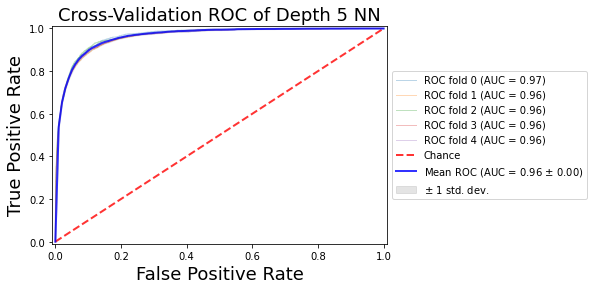

In [12]:
kfold = KFold(n_splits=5, shuffle=True)
inputs = x_d5.copy()
inputs = np.array(inputs)
inputs = np.stack(inputs)
targets = np.array(y_d5)
#targets = np.stack(targets)
targets = np.array([np.array(xi) for xi in targets])


n_classes = 51

acc_per_fold = []
f1_per_fold = []
time_per_fold = []

acc_per_fold_plut = []
f1_per_fold_plut = []
time_per_fold_plut = []

acc_per_fold_mwpm = []
f1_per_fold_mwpm = []
time_per_fold_mwpm = []

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
plt.figure(figsize=(10,10))

aucs_classes = {}
for i in mlb.classes_:
    aucs_classes[i] = []
    
fig, ax = plt.subplots()

# K-fold Cross Validation model evaluation
for i, (train, test) in enumerate(kfold.split(inputs, targets)):
    i_train = inputs[train].copy()
    i_test = inputs[test].copy()
    x_test_d5 = i_test[:,:2]
    inputs_train = i_train[:,3:]
    inputs_test = i_test[:,3:]
    
    ####################################################################################################
    #test MWPM decoder for this fold
    #labels = targets[train], features = inputs[train]
    #x_test_d5 = translate_to_graph(testData_d5_MWPM, targets[test], mlb)
    decoding_d5, time_mwpm = do_new_decoding(x_test_d5, 5, 0)
    decoding_d5['combine'] = decoding_d5[[0, 1]].values.tolist()
    decoding_d5['combine'].apply(lambda x: x[0].extend(x[1]))
    decoding_d5 = np.array(decoding_d5[0])
                                              
    time_per_fold_mwpm.append(time_mwpm)
                                              
    pred_mwpm = mlb.transform(decoding_d5)
    if fold_no < 5:
        acc = partial_accuracy(targets[test], pred_mwpm)
    else:
        acc, contingency_mwpm = partial_accuracy_and_contingency(targets[test], pred_mwpm, mlb)
        
    acc_per_fold_mwpm.append(acc)
    f1_per_fold_mwpm.append(f1_score(targets[test], pred_mwpm, average='micro'))
    
    #####################################################################################################
    #test the plut decoder for this fold
    
    lookup_d5 = lookup_decoder(5)
    
    lookup_d5 = train_plut(lookup_d5, inputs_train, targets[train])
    
    start = time.time_ns()
    pred_plut_d5 = test_plut(lookup_d5, inputs_test)
    end = time.time_ns() 
    time_per_fold_plut.append((end - start)/ (10 ** 9))
    
    if fold_no < 5:
        acc = partial_accuracy(targets[test], pred_plut_d5)
    else:
        acc, contingency_plut = partial_accuracy_and_contingency(targets[test], pred_plut_d5, mlb)
        
    acc_per_fold_plut.append(acc)
    f1_per_fold_plut.append(f1_score(targets[test], pred_plut_d5, average='micro'))

    #####################################################################################################
    #Test the NN decoder for this fold
    
    model_d5 = compile_FFNN_model_DepthFive(5)
    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    inputs_train = np.asarray(inputs_train).astype('int32')
    inputs_test = np.asarray(inputs_test).astype('int32')
    
    # Fit data to model
    
    history = model_d5.fit(
    inputs_train,
    targets[train],
    validation_split=.25,
    epochs = 800
)
   # Generate generalization metrics
    scores = model_d5.evaluate(inputs_test, targets[test], verbose=0)
    
    start = time.time_ns()
    predictions_d5 = model_d5.predict(inputs_test)
    end = time.time_ns() 
    time_per_fold.append((end - start)/ (10 ** 9))
    
    #threshold based on previous tests with train_test_split in hyperparameter tuning
    pred=predictions_d5.copy() #change here
    pred[pred>=.4]=1 
    pred[pred<.4]=0
    
    if fold_no < 5:
        acc = scores[1]
    else:
        acc, contingency_nn = partial_accuracy_and_contingency(targets[test], pred, mlb)

    acc_per_fold.append(acc)
    f1_per_fold.append(f1_score(targets[test], pred, average='micro'))

    
    # Increase fold number
    fold_no = fold_no + 1
    
    fpr, tpr, thresholds = roc_curve(targets[test].ravel(), predictions_d5.ravel())
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    
    #get the AUCs of each class, used to get average AUC of each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(targets[test][:, i], predictions_d5[:, i]) 
        aucs_classes[mlb.classes_[i]].append(auc(fpr[i], tpr[i]))
        
        
#########################################################################################################
#compute McNemar's statistic on results of last fold

mcnemar_results_mwpm = {}
mcnemar_results_plut = {}

for class_ in mlb.classes_:
    
    #compute the x^2 for NN and MWPM
    mcnemar_results_mwpm[class_]=contingency_table_and_t(contingency_nn[class_], contingency_mwpm[class_])[1]    
    #comput the x^2 for NN and PLUT
    mcnemar_results_plut[class_] = contingency_table_and_t(contingency_nn[class_], contingency_plut[class_])[1]
        
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('------------------------------------------------------------------------')
print('------------------------------------------------------------------------')
print('Average scores for all folds of MWPM:')
print(f'> Accuracy: {np.mean(acc_per_fold_mwpm)} (+- {np.std(acc_per_fold_mwpm)})')
print(f'> F1: {np.mean(f1_per_fold_mwpm)}(+- {np.std(f1_per_fold_mwpm)})')
print(f'> Time: {np.mean(time_per_fold_mwpm)} (+- {np.std(time_per_fold_mwpm)})')
print("##############################################################################")
print('Average scores for all folds of PLUT:')
print(f'> Accuracy: {np.mean(acc_per_fold_plut)} (+- {np.std(acc_per_fold_plut)})')
print(f'> F1: {np.mean(f1_per_fold_plut)}(+- {np.std(f1_per_fold_plut)})')
print(f'> Time: {np.mean(time_per_fold_plut)} (+- {np.std(time_per_fold_plut)})')
print("##############################################################################")
print('Average scores for all folds of NN:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> F1: {np.mean(f1_per_fold)}(+- {np.std(f1_per_fold)})')
print(f'> Time: {np.mean(time_per_fold)} (+- {np.std(time_per_fold)})')
print("##############################################################################")
for key in aucs_classes:
    cleanedList = [x for x in aucs_classes[key] if str(x) != 'nan']
    print(f'> AUC for class {key}: {np.mean(cleanedList)} (+- {np.std(cleanedList)})') #this has to be a for loop
    print("X^2 for MWPM and NN: " + str(mcnemar_results_mwpm[key]))  
    print("X^2 for PLUT and NN: " + str(mcnemar_results_plut[key]))
    
print("###################################################################################")
print("TOTAL F1 NN: " + str(f1_per_fold))
print("TOTAL F1 PLUT: " + str(f1_per_fold_plut))
print("TOTAL F1 MWPM: " + str(f1_per_fold_mwpm))
print("TOTAL ACC NN: " + str(acc_per_fold))
print("TOTAL ACC PLUT: " + str(acc_per_fold_plut))
print("TOTAL ACC MWPM: " + str(acc_per_fold_mwpm))
print("TOTAL TIME NN: " + str(time_per_fold))
print("TOTAL TIME PLUT: " + str(time_per_fold_plut))
print("TOTAL TIME MWPM: " + str(time_per_fold_mwpm))
print('------------------------------------------------------------------------')


plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate',fontsize=18)
plt.ylabel('True Positive Rate',fontsize=18)
plt.title('Cross-Validation ROC of Depth 5 NN',fontsize=18)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/150
7941/7941 [==============================] - 14s 2ms/step - loss: 0.1626 - accuracy: 0.0508 - val_loss: 0.1871 - val_accuracy: 0.1021
Epoch 2/150
7941/7941 [==============================] - 14s 2ms/step - loss: 0.1424 - accuracy: 0.1243 - val_loss: 0.1547 - val_accuracy: 0.2459
Epoch 3/150
7941/7941 [==============================] - 15s 2ms/step - loss: 0.1144 - accuracy: 0.1863 - val_loss: 0.1231 - val_accuracy: 0.3035
Epoch 4/150
7941/7941 [==============================] - 19s 2ms/step - loss: 0.0943 - accuracy: 0.2082 - val_loss: 0.1068 - val_accuracy: 0.3038
Epoch 5/150
7941/7941 [==============================] - 17s 2ms/step - loss: 0.0823 - accuracy: 0.2231 - val_loss: 0.0981 - val_accuracy: 0.3182
Epoch 6/150
7941/7941 [==============================] - 17s 2ms/step - loss: 0.0749 - accuracy: 0.2269 - val_loss: 0.0919 - val_accuracy: 0.3407
Epoch 7/150
7941/7941 [====

7941/7941 [==============================] - 15s 2ms/step - loss: 0.0364 - accuracy: 0.2296 - val_loss: 0.0490 - val_accuracy: 0.2993
Epoch 57/150
7941/7941 [==============================] - 15s 2ms/step - loss: 0.0363 - accuracy: 0.2295 - val_loss: 0.0491 - val_accuracy: 0.3153
Epoch 58/150
7941/7941 [==============================] - 15s 2ms/step - loss: 0.0362 - accuracy: 0.2293 - val_loss: 0.0492 - val_accuracy: 0.3075
Epoch 59/150
7941/7941 [==============================] - 15s 2ms/step - loss: 0.0360 - accuracy: 0.2293 - val_loss: 0.0483 - val_accuracy: 0.2988
Epoch 60/150
7941/7941 [==============================] - 15s 2ms/step - loss: 0.0359 - accuracy: 0.2293 - val_loss: 0.0484 - val_accuracy: 0.3233
Epoch 61/150
7941/7941 [==============================] - 15s 2ms/step - loss: 0.0358 - accuracy: 0.2286 - val_loss: 0.0487 - val_accuracy: 0.3154
Epoch 62/150
7941/7941 [==============================] - 15s 2ms/step - loss: 0.0357 - accuracy: 0.2285 - val_loss: 0.0479 - val_a

Epoch 112/150
7941/7941 [==============================] - 14s 2ms/step - loss: 0.0317 - accuracy: 0.2235 - val_loss: 0.0442 - val_accuracy: 0.3151
Epoch 113/150
7941/7941 [==============================] - 14s 2ms/step - loss: 0.0317 - accuracy: 0.2233 - val_loss: 0.0448 - val_accuracy: 0.3027
Epoch 114/150
7941/7941 [==============================] - 14s 2ms/step - loss: 0.0316 - accuracy: 0.2247 - val_loss: 0.0444 - val_accuracy: 0.2966
Epoch 115/150
7941/7941 [==============================] - 14s 2ms/step - loss: 0.0316 - accuracy: 0.2240 - val_loss: 0.0447 - val_accuracy: 0.3085
Epoch 116/150
7941/7941 [==============================] - 14s 2ms/step - loss: 0.0315 - accuracy: 0.2241 - val_loss: 0.0446 - val_accuracy: 0.3025
Epoch 117/150
7941/7941 [==============================] - 14s 2ms/step - loss: 0.0314 - accuracy: 0.2247 - val_loss: 0.0441 - val_accuracy: 0.3124
Epoch 118/150
7941/7941 [==============================] - 14s 2ms/step - loss: 0.0314 - accuracy: 0.2241 - val_

<ipython-input-14-1a1788afa7e3>:140: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
C:\Users\Bensom2\miniconda3\envs\my_qiskit\lib\site-packages\sklearn\metrics\_ranking.py:949: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "


------------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/150
7941/7941 [==============================] - 14s 2ms/step - loss: 0.1626 - accuracy: 0.0573 - val_loss: 0.1865 - val_accuracy: 0.1414
Epoch 2/150
7941/7941 [==============================] - 13s 2ms/step - loss: 0.1406 - accuracy: 0.1760 - val_loss: 0.1485 - val_accuracy: 0.2735
Epoch 3/150
7941/7941 [==============================] - 13s 2ms/step - loss: 0.1101 - accuracy: 0.2145 - val_loss: 0.1221 - val_accuracy: 0.3055
Epoch 4/150
7941/7941 [==============================] - 14s 2ms/step - loss: 0.0940 - accuracy: 0.2131 - val_loss: 0.1086 - val_accuracy: 0.3089
Epoch 5/150
7941/7941 [==============================] - 14s 2ms/step - loss: 0.0833 - accuracy: 0.2137 - val_loss: 0.0990 - val_accuracy: 0.3115
Epoch 6/150
7941/7941 [==============================] - 14s 2ms/step - loss: 0.0752 - accuracy: 0.2199 - val_loss: 0.0914 - val_accuracy: 0.3023
Epoch 7/150
7941/7941 [====

7941/7941 [==============================] - 14s 2ms/step - loss: 0.0363 - accuracy: 0.2249 - val_loss: 0.0488 - val_accuracy: 0.3108
Epoch 57/150
7941/7941 [==============================] - 14s 2ms/step - loss: 0.0361 - accuracy: 0.2251 - val_loss: 0.0481 - val_accuracy: 0.3015
Epoch 58/150
7941/7941 [==============================] - 14s 2ms/step - loss: 0.0360 - accuracy: 0.2243 - val_loss: 0.0484 - val_accuracy: 0.3011
Epoch 59/150
7941/7941 [==============================] - 14s 2ms/step - loss: 0.0359 - accuracy: 0.2247 - val_loss: 0.0477 - val_accuracy: 0.3033
Epoch 60/150
7941/7941 [==============================] - 14s 2ms/step - loss: 0.0358 - accuracy: 0.2242 - val_loss: 0.0487 - val_accuracy: 0.3072
Epoch 61/150
7941/7941 [==============================] - 14s 2ms/step - loss: 0.0356 - accuracy: 0.2250 - val_loss: 0.0476 - val_accuracy: 0.3120
Epoch 62/150
7941/7941 [==============================] - 14s 2ms/step - loss: 0.0355 - accuracy: 0.2248 - val_loss: 0.0478 - val_a

Epoch 112/150
7941/7941 [==============================] - 14s 2ms/step - loss: 0.0317 - accuracy: 0.2227 - val_loss: 0.0436 - val_accuracy: 0.2999
Epoch 113/150
7941/7941 [==============================] - 14s 2ms/step - loss: 0.0316 - accuracy: 0.2216 - val_loss: 0.0442 - val_accuracy: 0.3069
Epoch 114/150
7941/7941 [==============================] - 14s 2ms/step - loss: 0.0316 - accuracy: 0.2215 - val_loss: 0.0447 - val_accuracy: 0.2978
Epoch 115/150
7941/7941 [==============================] - 14s 2ms/step - loss: 0.0315 - accuracy: 0.2227 - val_loss: 0.0437 - val_accuracy: 0.2920
Epoch 116/150
7941/7941 [==============================] - 14s 2ms/step - loss: 0.0314 - accuracy: 0.2222 - val_loss: 0.0446 - val_accuracy: 0.3006
Epoch 117/150
7941/7941 [==============================] - 14s 2ms/step - loss: 0.0314 - accuracy: 0.2227 - val_loss: 0.0443 - val_accuracy: 0.3089
Epoch 118/150
7941/7941 [==============================] - 14s 2ms/step - loss: 0.0313 - accuracy: 0.2221 - val_

<ipython-input-14-1a1788afa7e3>:140: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


------------------------------------------------------------------------
Training for fold 3 ...
Epoch 1/150
7941/7941 [==============================] - 13s 2ms/step - loss: 0.1619 - accuracy: 0.0449 - val_loss: 0.1875 - val_accuracy: 0.1129
Epoch 2/150
7941/7941 [==============================] - 12s 2ms/step - loss: 0.1416 - accuracy: 0.1318 - val_loss: 0.1486 - val_accuracy: 0.2709
Epoch 3/150
7941/7941 [==============================] - 12s 2ms/step - loss: 0.1094 - accuracy: 0.1974 - val_loss: 0.1191 - val_accuracy: 0.2981
Epoch 4/150
7941/7941 [==============================] - 13s 2ms/step - loss: 0.0914 - accuracy: 0.2187 - val_loss: 0.1050 - val_accuracy: 0.3130
Epoch 5/150
7941/7941 [==============================] - 13s 2ms/step - loss: 0.0803 - accuracy: 0.2263 - val_loss: 0.0954 - val_accuracy: 0.3251
Epoch 6/150
7941/7941 [==============================] - 13s 2ms/step - loss: 0.0732 - accuracy: 0.2286 - val_loss: 0.0896 - val_accuracy: 0.3311
Epoch 7/150
7941/7941 [====

7941/7941 [==============================] - 13s 2ms/step - loss: 0.0361 - accuracy: 0.2203 - val_loss: 0.0486 - val_accuracy: 0.3042
Epoch 57/150
7941/7941 [==============================] - 13s 2ms/step - loss: 0.0360 - accuracy: 0.2208 - val_loss: 0.0480 - val_accuracy: 0.2968
Epoch 58/150
7941/7941 [==============================] - 13s 2ms/step - loss: 0.0358 - accuracy: 0.2203 - val_loss: 0.0479 - val_accuracy: 0.3051
Epoch 59/150
7941/7941 [==============================] - 13s 2ms/step - loss: 0.0357 - accuracy: 0.2202 - val_loss: 0.0483 - val_accuracy: 0.3042
Epoch 60/150
7941/7941 [==============================] - 13s 2ms/step - loss: 0.0356 - accuracy: 0.2204 - val_loss: 0.0480 - val_accuracy: 0.3022
Epoch 61/150
7941/7941 [==============================] - 13s 2ms/step - loss: 0.0355 - accuracy: 0.2195 - val_loss: 0.0475 - val_accuracy: 0.3021
Epoch 62/150
7941/7941 [==============================] - 13s 2ms/step - loss: 0.0353 - accuracy: 0.2194 - val_loss: 0.0475 - val_a

Epoch 112/150
7941/7941 [==============================] - 13s 2ms/step - loss: 0.0315 - accuracy: 0.2176 - val_loss: 0.0441 - val_accuracy: 0.2889
Epoch 113/150
7941/7941 [==============================] - 13s 2ms/step - loss: 0.0315 - accuracy: 0.2169 - val_loss: 0.0438 - val_accuracy: 0.3186
Epoch 114/150
7941/7941 [==============================] - 13s 2ms/step - loss: 0.0314 - accuracy: 0.2181 - val_loss: 0.0439 - val_accuracy: 0.2840
Epoch 115/150
7941/7941 [==============================] - 13s 2ms/step - loss: 0.0314 - accuracy: 0.2178 - val_loss: 0.0441 - val_accuracy: 0.2885
Epoch 116/150
7941/7941 [==============================] - 13s 2ms/step - loss: 0.0313 - accuracy: 0.2184 - val_loss: 0.0444 - val_accuracy: 0.3072
Epoch 117/150
7941/7941 [==============================] - 13s 2ms/step - loss: 0.0313 - accuracy: 0.2176 - val_loss: 0.0435 - val_accuracy: 0.2974
Epoch 118/150
7941/7941 [==============================] - 13s 2ms/step - loss: 0.0312 - accuracy: 0.2188 - val_

<ipython-input-14-1a1788afa7e3>:140: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
C:\Users\Bensom2\miniconda3\envs\my_qiskit\lib\site-packages\sklearn\metrics\_ranking.py:949: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "


[20000, 0]
[0, 0]
both b and c are zero
[20000, 0]
[0, 0]
both b and c are zero
[18630, 519]
[738, 113]
[18811, 338]
[37, 814]
[19269, 330]
[229, 172]
[19072, 527]
[133, 268]
[19682, 164]
[64, 90]
[19198, 648]
[88, 66]
[19755, 128]
[51, 66]
[19243, 640]
[43, 74]
[19642, 239]
[66, 53]
[19271, 610]
[38, 81]
[19537, 325]
[65, 73]
[19244, 618]
[48, 90]
[18297, 1126]
[225, 352]
[18873, 550]
[226, 351]
[18542, 919]
[271, 268]
[18941, 520]
[164, 375]
[19458, 309]
[113, 120]
[19109, 658]
[98, 135]
[19576, 222]
[103, 99]
[19195, 603]
[70, 132]
[19653, 196]
[53, 98]
[19268, 581]
[44, 107]
[19629, 203]
[84, 84]
[19212, 620]
[45, 123]
[19357, 478]
[97, 68]
[19208, 627]
[46, 119]
[19101, 392]
[111, 396]
[19027, 466]
[91, 416]
[19054, 408]
[123, 415]
[18982, 480]
[101, 437]
[19290, 506]
[106, 98]
[19151, 645]
[96, 108]
[19611, 232]
[68, 89]
[19243, 600]
[48, 109]
[19616, 244]
[75, 65]
[19270, 590]
[64, 76]
[19524, 320]
[80, 76]
[19232, 612]
[62, 94]
[19409, 367]
[141, 83]
[19070, 706]
[146, 78]
[184

<Figure size 720x720 with 0 Axes>

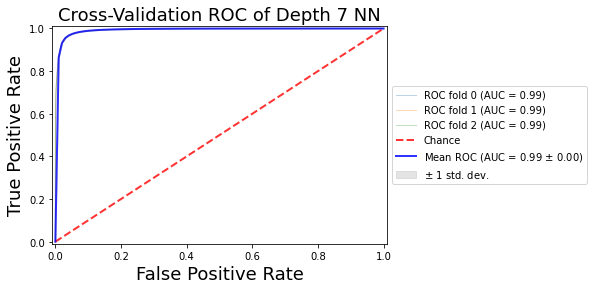

In [14]:
kfold = KFold(n_splits=3, shuffle=True)
inputs = x_d7.copy()
inputs = np.array(inputs)
inputs = np.stack(inputs)
targets = np.array(y_d7)
targets = np.array([np.array(xi) for xi in targets])

n_classes = 99

acc_per_fold = []
f1_per_fold = []
time_per_fold = []

acc_per_fold_plut = []
f1_per_fold_plut = []
time_per_fold_plut = []

acc_per_fold_mwpm = []
f1_per_fold_mwpm = []
time_per_fold_mwpm = []

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
plt.figure(figsize=(10,10))

aucs_classes = {}
for i in mlb_d7.classes_:
    aucs_classes[i] = []
    
fig, ax = plt.subplots()

# K-fold Cross Validation model evaluation
fold_no = 1
for i, (train, test) in enumerate(kfold.split(inputs, targets)):
    i_train = inputs[train].copy()
    i_test = inputs[test].copy()
    t_test = targets[test].copy()
    x_test_d7 = i_test[:,:2]
    inputs_train = i_train[:,3:]
    inputs_test = i_test[:,3:]
    indices = np.random.choice(inputs[test].shape[0], 20000, replace=False)
    x_test_d7 = x_test_d7[indices]
    inputs_test_2 = inputs_test[indices]
    targets_test_2 = targets[test][indices]
    ####################################################################################################
    #test MWPM decoder for this fold
    #labels = targets[train], features = inputs[train]
   # x_test_d7 = translate_to_graph(testData_d7_MWPM, targs, mlb_d7)
    decoding_d7, time_mwpm = do_new_decoding(x_test_d7, 7, 0)
    decoding_d7['combine'] = decoding_d7[[0, 1]].values.tolist()
    decoding_d7['combine'].apply(lambda x: x[0].extend(x[1]))
    decoding_d7 = np.array(decoding_d7[0])
                                              
    time_per_fold_mwpm.append(time_mwpm)
                                              
    pred_mwpm = mlb_d7.transform(decoding_d7)

    if fold_no < 3:
        acc = partial_accuracy(targets_test_2, pred_mwpm)
    else:
        acc, contingency_mwpm = partial_accuracy_and_contingency(targets_test_2, pred_mwpm, mlb_d7)
        
    acc_per_fold_mwpm.append(acc)
    f1_per_fold_mwpm.append(f1_score(targets_test_2, pred_mwpm, average='micro'))

    #####################################################################################################
    #test the plut decoder for this fold
    
    lookup_d7 = lookup_decoder(7)
    
    lookup_d7 = train_plut(lookup_d7, inputs_train, targets[train])
    
    start = time.time_ns()
    pred_plut_d7 = test_plut(lookup_d7, inputs_test)
    end = time.time_ns() 
    time_per_fold_plut.append((end - start)/ (10 ** 9))
    
    if fold_no < 3:
        acc = partial_accuracy(targets[test], pred_plut_d7)
        f1 = f1_score(targets[test], pred_plut_d7, average='micro')
    else:
        pred_plut_d7 = test_plut(lookup_d7, inputs_test_2)
        f1 = f1_score(targets_test_2, pred_plut_d7, average='micro')
        acc, contingency_plut = partial_accuracy_and_contingency(targets_test_2, pred_plut_d7, mlb_d7)
        
    acc_per_fold_plut.append(acc)
    f1_per_fold_plut.append(f1)
    
    #####################################################################################################
    #Test the NN decoder for this fold
    
    model_d7 = compile_FFNN_model_DepthSeven(7)

    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    inputs_train = np.asarray(inputs_train).astype('int32')
    inputs_test = np.asarray(inputs_test).astype('int32')
    inputs_test_2 = np.asarray(inputs_test_2).astype('int32')
    
    # Fit data to model
    history = model_d7.fit(
        x=inputs_train ,
        y=targets[train],
        validation_split=.25,
        epochs= 150)
    
   # Generate generalization metrics
    scores = model_d7.evaluate(inputs_test, targets[test], verbose=0)
    
    start = time.time_ns()
    predictions_d7 = model_d7.predict(inputs_test)
    end = time.time_ns() 
    time_per_fold.append((end - start)/ (10 ** 9))
    
    #threshold based on previous tests with train_test_split in hyperparameter tuning
    pred=predictions_d7.copy() #change here
    pred[pred>=.5]=1 
    pred[pred<.5]=0
     
    if fold_no < 3:
        acc = scores[1]
        f1 = f1_score(targets[test], pred, average='micro')
    else:
        pred = model_d7.predict(inputs_test_2)
        pred[pred>=.5]=1 
        pred[pred<.5]=0
        acc, contingency_nn = partial_accuracy_and_contingency(targets_test_2, pred, mlb_d7)
        f1 = f1_score(targets_test_2, pred, average='micro')
 
    acc_per_fold.append(acc)
    f1_per_fold.append(f1)

    # Increase fold number
    fold_no = fold_no + 1
    
    fpr, tpr, thresholds = roc_curve(targets[test].ravel(), predictions_d7.ravel())
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    
    #get the AUCs of each class, used to get average AUC of each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(targets[test][:, i], predictions_d7[:, i]) 
        aucs_classes[mlb_d7.classes_[i]].append(auc(fpr[i], tpr[i]))

#########################################################################################################
#compute McNemar's statistic on results of last fold

mcnemar_results_mwpm = {}
mcnemar_results_plut = {}

for class_ in mlb_d7.classes_:
    
    #compute the x^2 for NN and MWPM
    mcnemar_results_mwpm[class_]=contingency_table_and_t(contingency_nn[class_], contingency_mwpm[class_])[1]    
    #comput the x^2 for NN and PLUT
    mcnemar_results_plut[class_] = contingency_table_and_t(contingency_nn[class_], contingency_plut[class_])[1]
        
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('------------------------------------------------------------------------')
print('Average scores for all folds of MWPM:')
print(f'> Accuracy: {np.mean(acc_per_fold_mwpm)} (+- {np.std(acc_per_fold_mwpm)})')
print(f'> F1: {np.mean(f1_per_fold_mwpm)}(+- {np.std(f1_per_fold_mwpm)})')
print(f'> Time: {np.mean(time_per_fold_mwpm)} (+- {np.std(time_per_fold_mwpm)})')
print('Average scores for all folds of PLUT:')
print(f'> Accuracy: {np.mean(acc_per_fold_plut)} (+- {np.std(acc_per_fold_plut)})')
print(f'> F1: {np.mean(f1_per_fold_plut)}(+- {np.std(f1_per_fold_plut)})')
print(f'> Time: {np.mean(time_per_fold_plut)} (+- {np.std(time_per_fold_plut)})')
print('Average scores for all folds of NN:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> F1: {np.mean(f1_per_fold)}(+- {np.std(f1_per_fold)})')
print(f'> Time: {np.mean(time_per_fold)} (+- {np.std(time_per_fold)})')
for key in aucs_classes:
    cleanedList = [x for x in aucs_classes[key] if str(x) != 'nan']
    print(f'> AUC for class {key}: {np.mean(cleanedList)} (+- {np.std(cleanedList)})') #this has to be a for loop
    print("X^2 for MWPM and NN: " + str(mcnemar_results_mwpm[key]))  
    print("X^2 for PLUT and NN: " + str(mcnemar_results_plut[key]))
print("###################################################################################")
print("TOTAL F1 NN: " + str(f1_per_fold))
print("TOTAL F1 PLUT: " + str(f1_per_fold_plut))
print("TOTAL F1 MWPM: " + str(f1_per_fold_mwpm))
print("TOTAL ACC NN: " + str(acc_per_fold))
print("TOTAL ACC PLUT: " + str(acc_per_fold_plut))
print("TOTAL ACC MWPM: " + str(acc_per_fold_mwpm))
print("TOTAL TIME NN: " + str(time_per_fold))
print("TOTAL TIME PLUT: " + str(time_per_fold_plut))
print("TOTAL TIME MWPM: " + str(time_per_fold_mwpm))
print('------------------------------------------------------------------------')


plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate',fontsize=18)
plt.ylabel('True Positive Rate',fontsize=18)
plt.title('Cross-Validation ROC of Depth 7 NN',fontsize=18)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [15]:
print("TOTAL F1 NN: " + str(f1_per_fold))
print("TOTAL F1 PLUT: " + str(f1_per_fold_plut))
print("TOTAL F1 MWPM: " + str(f1_per_fold_mwpm))
print("TOTAL ACC NN: " + str(acc_per_fold))
print("TOTAL ACC PLUT: " + str(acc_per_fold_plut))
print("TOTAL ACC MWPM: " + str(acc_per_fold_mwpm))
print("TOTAL TIME NN: " + str(time_per_fold))
print("TOTAL TIME PLUT: " + str(time_per_fold_plut))
print("TOTAL TIME MWPM: " + str(time_per_fold_mwpm))
print('-----------------------------------------------')

TOTAL F1 NN: [0.8201395877498923, 0.821418399316434, 0.8191169192493412]
TOTAL F1 PLUT: [0.21600465905950167, 0.21577601491392678, 0.21589305684751825]
TOTAL F1 MWPM: [0.6980389857833798, 0.6996876498871094, 0.6984820957627614]
TOTAL ACC NN: [0.24212782084941864, 0.2427195906639099, 0.9863404040403925]
TOTAL ACC PLUT: [0.9621109258977504, 0.9620720615785512, 0.9621106060604908]
TOTAL ACC MWPM: [0.9739863636363807, 0.9740696969697087, 0.9740161616161771]
TOTAL TIME NN: [2.9411304, 2.7462049, 2.7639117]
TOTAL TIME PLUT: [3.5267561, 3.5152217, 3.4733686]
TOTAL TIME MWPM: [2171.313826099998, 2112.2217765999876, 2108.1117772000052]
-----------------------------------------------


<ipython-input-17-ce8ecd95ec10>:58: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
C:\Users\Bensom2\miniconda3\envs\my_qiskit\lib\site-packages\sklearn\metrics\_ranking.py:949: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "


[20000, 0]
[0, 0]
both b and c are zero
[20000, 0]
[0, 0]
both b and c are zero
[18630, 519]
[738, 113]
[18811, 338]
[37, 814]
[19269, 330]
[229, 172]
[19072, 527]
[133, 268]
[19682, 164]
[64, 90]
[19198, 648]
[88, 66]
[19755, 128]
[51, 66]
[19243, 640]
[43, 74]
[19642, 239]
[66, 53]
[19271, 610]
[38, 81]
[19537, 325]
[65, 73]
[19244, 618]
[48, 90]
[18297, 1126]
[225, 352]
[18873, 550]
[226, 351]
[18542, 919]
[271, 268]
[18941, 520]
[164, 375]
[19458, 309]
[113, 120]
[19109, 658]
[98, 135]
[19576, 222]
[103, 99]
[19195, 603]
[70, 132]
[19653, 196]
[53, 98]
[19268, 581]
[44, 107]
[19629, 203]
[84, 84]
[19212, 620]
[45, 123]
[19357, 478]
[97, 68]
[19208, 627]
[46, 119]
[19101, 392]
[111, 396]
[19027, 466]
[91, 416]
[19054, 408]
[123, 415]
[18982, 480]
[101, 437]
[19290, 506]
[106, 98]
[19151, 645]
[96, 108]
[19611, 232]
[68, 89]
[19243, 600]
[48, 109]
[19616, 244]
[75, 65]
[19270, 590]
[64, 76]
[19524, 320]
[80, 76]
[19232, 612]
[62, 94]
[19409, 367]
[141, 83]
[19070, 706]
[146, 78]
[184

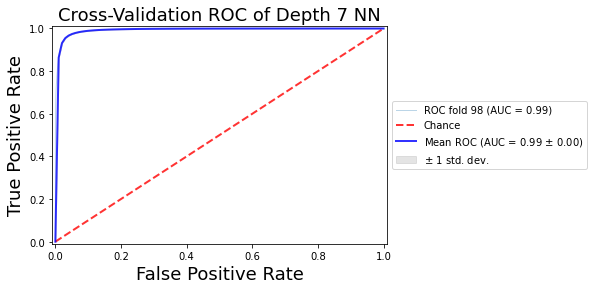

In [17]:
#test MWPM decoder for this fold
#labels = targets[train], features = inputs[train]
# x_test_d7 = translate_to_graph(testData_d7_MWPM, targs, mlb_d7)
"""
decoding_d7, time_mwpm = do_new_decoding(x_test_d7, 7, 0)
decoding_d7['combine'] = decoding_d7[[0, 1]].values.tolist()
decoding_d7['combine'].apply(lambda x: x[0].extend(x[1]))
decoding_d7 = np.array(decoding_d7[0])

time_per_fold_mwpm.append(time_mwpm)

pred_mwpm = mlb_d7.transform(decoding_d7)

if fold_no < 3:
    acc = partial_accuracy(targets_test_2, pred_mwpm)
else:
    acc, contingency_mwpm = partial_accuracy_and_contingency(targets_test_2, pred_mwpm, mlb_d7)"""

#acc_per_fold_mwpm.append(acc)
#f1_per_fold_mwpm.append(f1_score(targets_test_2, pred_mwpm, average='micro'))

#####################################################################################################
#test the plut decoder for this fold

#lookup_d7 = lookup_decoder(7)

#lookup_d7 = train_plut(lookup_d7, inputs_train, targets[train])

#start = time.time_ns()
#pred_plut_d7 = test_plut(lookup_d7, inputs_test)
#end = time.time_ns() 
#time_per_fold_plut.append((end - start)/ (10 ** 9))

pred_plut_d7 = test_plut(lookup_d7, inputs_test_2)
#f1 = f1_score(targets_test_2, pred_plut_d7, average='micro')
acc, contingency_plut = partial_accuracy_and_contingency(targets_test_2, pred_plut_d7, mlb_d7)

#acc_per_fold_plut.append(acc)
#f1_per_fold_plut.append(f1)

#####################################################################################################
#Test the NN decoder for this fold
"""
model_d7 = compile_FFNN_model_DepthSeven(7)

# Generate a print
print('------------------------------------------------------------------------')
print(f'Training for fold {fold_no} ...')

# Fit data to model
history = model_d7.fit(
    x=inputs_train ,
    y=targets[train],
    validation_split=.25,
    epochs= 150)"""
inputs_test_2 = np.asarray(inputs_test_2).astype('int32')
fpr, tpr, thresholds = roc_curve(targets[test].ravel(), predictions_d7.ravel())
tprs.append(interp(mean_fpr, fpr, tpr))
tprs[-1][0] = 0.0
roc_auc = auc(fpr, tpr)
aucs.append(roc_auc)
plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

#get the AUCs of each class, used to get average AUC of each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(targets[test][:, i], predictions_d7[:, i]) 
    aucs_classes[mlb_d7.classes_[i]].append(auc(fpr[i], tpr[i]))

#########################################################################################################
#compute McNemar's statistic on results of last fold

mcnemar_results_mwpm = {}
mcnemar_results_plut = {}

for class_ in mlb_d7.classes_:
    
    #compute the x^2 for NN and MWPM
    mcnemar_results_mwpm[class_]=contingency_table_and_t(contingency_nn[class_], contingency_mwpm[class_])[1]    
    #comput the x^2 for NN and PLUT
    mcnemar_results_plut[class_] = contingency_table_and_t(contingency_nn[class_], contingency_plut[class_])[1]
        
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('------------------------------------------------------------------------')
print('Average scores for all folds of MWPM:')
print(f'> Accuracy: {np.mean(acc_per_fold_mwpm)} (+- {np.std(acc_per_fold_mwpm)})')
print(f'> F1: {np.mean(f1_per_fold_mwpm)}(+- {np.std(f1_per_fold_mwpm)})')
print(f'> Time: {np.mean(time_per_fold_mwpm)} (+- {np.std(time_per_fold_mwpm)})')
print('Average scores for all folds of PLUT:')
print(f'> Accuracy: {np.mean(acc_per_fold_plut)} (+- {np.std(acc_per_fold_plut)})')
print(f'> F1: {np.mean(f1_per_fold_plut)}(+- {np.std(f1_per_fold_plut)})')
print(f'> Time: {np.mean(time_per_fold_plut)} (+- {np.std(time_per_fold_plut)})')
print('Average scores for all folds of NN:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> F1: {np.mean(f1_per_fold)}(+- {np.std(f1_per_fold)})')
print(f'> Time: {np.mean(time_per_fold)} (+- {np.std(time_per_fold)})')
for key in aucs_classes:
    cleanedList = [x for x in aucs_classes[key] if str(x) != 'nan']
    print(f'> AUC for class {key}: {np.mean(cleanedList)} (+- {np.std(cleanedList)})') #this has to be a for loop
    print("X^2 for MWPM and NN: " + str(mcnemar_results_mwpm[key]))  
    print("X^2 for PLUT and NN: " + str(mcnemar_results_plut[key]))
print("###################################################################################")
print("TOTAL F1 NN: " + str(f1_per_fold))
print("TOTAL F1 PLUT: " + str(f1_per_fold_plut))
print("TOTAL F1 MWPM: " + str(f1_per_fold_mwpm))
print("TOTAL ACC NN: " + str(acc_per_fold))
print("TOTAL ACC PLUT: " + str(acc_per_fold_plut))
print("TOTAL ACC MWPM: " + str(acc_per_fold_mwpm))
print("TOTAL TIME NN: " + str(time_per_fold))
print("TOTAL TIME PLUT: " + str(time_per_fold_plut))
print("TOTAL TIME MWPM: " + str(time_per_fold_mwpm))
print('------------------------------------------------------------------------')


plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate',fontsize=18)
plt.ylabel('True Positive Rate',fontsize=18)
plt.title('Cross-Validation ROC of Depth 7 NN',fontsize=18)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

<ipython-input-18-383d0a3a81ae>:74: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
C:\Users\Bensom2\miniconda3\envs\my_qiskit\lib\site-packages\sklearn\metrics\_ranking.py:949: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "


[20000, 0]
[0, 0]
both b and c are zero
[20000, 0]
[0, 0]
both b and c are zero
[18630, 519]
[738, 113]
[18811, 338]
[37, 814]
[19269, 330]
[229, 172]
[19072, 527]
[133, 268]
[19682, 164]
[64, 90]
[19198, 648]
[88, 66]
[19755, 128]
[51, 66]
[19243, 640]
[43, 74]
[19642, 239]
[66, 53]
[19271, 610]
[38, 81]
[19537, 325]
[65, 73]
[19244, 618]
[48, 90]
[18297, 1126]
[225, 352]
[18873, 550]
[226, 351]
[18542, 919]
[271, 268]
[18941, 520]
[164, 375]
[19458, 309]
[113, 120]
[19109, 658]
[98, 135]
[19576, 222]
[103, 99]
[19195, 603]
[70, 132]
[19653, 196]
[53, 98]
[19268, 581]
[44, 107]
[19629, 203]
[84, 84]
[19212, 620]
[45, 123]
[19357, 478]
[97, 68]
[19208, 627]
[46, 119]
[19101, 392]
[111, 396]
[19027, 466]
[91, 416]
[19054, 408]
[123, 415]
[18982, 480]
[101, 437]
[19290, 506]
[106, 98]
[19151, 645]
[96, 108]
[19611, 232]
[68, 89]
[19243, 600]
[48, 109]
[19616, 244]
[75, 65]
[19270, 590]
[64, 76]
[19524, 320]
[80, 76]
[19232, 612]
[62, 94]
[19409, 367]
[141, 83]
[19070, 706]
[146, 78]
[184

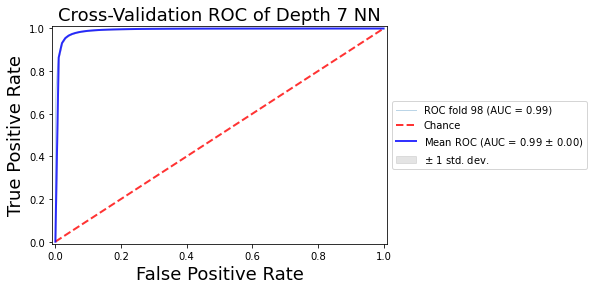

In [18]:
#test MWPM decoder for this fold
#labels = targets[train], features = inputs[train]
# x_test_d7 = translate_to_graph(testData_d7_MWPM, targs, mlb_d7)
"""
decoding_d7, time_mwpm = do_new_decoding(x_test_d7, 7, 0)
decoding_d7['combine'] = decoding_d7[[0, 1]].values.tolist()
decoding_d7['combine'].apply(lambda x: x[0].extend(x[1]))
decoding_d7 = np.array(decoding_d7[0])

time_per_fold_mwpm.append(time_mwpm)

pred_mwpm = mlb_d7.transform(decoding_d7)

if fold_no < 3:
    acc = partial_accuracy(targets_test_2, pred_mwpm)
else:
    acc, contingency_mwpm = partial_accuracy_and_contingency(targets_test_2, pred_mwpm, mlb_d7)"""

#acc_per_fold_mwpm.append(acc)
#f1_per_fold_mwpm.append(f1_score(targets_test_2, pred_mwpm, average='micro'))

#####################################################################################################
#test the plut decoder for this fold

#lookup_d7 = lookup_decoder(7)

#lookup_d7 = train_plut(lookup_d7, inputs_train, targets[train])

#start = time.time_ns()
#pred_plut_d7 = test_plut(lookup_d7, inputs_test)
#end = time.time_ns() 
#time_per_fold_plut.append((end - start)/ (10 ** 9))

if fold_no < 3:
    acc = partial_accuracy(targets[test], pred_plut_d7)
    f1 = f1_score(targets[test], pred_plut_d7, average='micro')
else:
    pred_plut_d7 = test_plut(lookup_d7, inputs_test_2)
    #f1 = f1_score(targets_test_2, pred_plut_d7, average='micro')
    acc, contingency_plut = partial_accuracy_and_contingency(targets_test_2, pred_plut_d7, mlb_d7)

#acc_per_fold_plut.append(acc)
#f1_per_fold_plut.append(f1)

#####################################################################################################
#Test the NN decoder for this fold
"""
model_d7 = compile_FFNN_model_DepthSeven(7)

# Generate a print
print('------------------------------------------------------------------------')
print(f'Training for fold {fold_no} ...')

# Fit data to model
history = model_d7.fit(
    x=inputs_train ,
    y=targets[train],
    validation_split=.25,
    epochs= 150)"""
inputs_test_2 = np.asarray(inputs_test_2).astype('int32')
pred = model_d7.predict(inputs_test_2)
pred[pred>=.5]=1 
pred[pred<.5]=0
acc, contingency_nn = partial_accuracy_and_contingency(targets_test_2, pred, mlb_d7)
f1 = f1_score(targets_test_2, pred, average='micro')

#acc_per_fold.append(acc)
f1_per_fold.append(f1)

# Increase fold number
fold_no = fold_no + 1

fpr, tpr, thresholds = roc_curve(targets[test].ravel(), predictions_d7.ravel())
tprs.append(interp(mean_fpr, fpr, tpr))
tprs[-1][0] = 0.0
roc_auc = auc(fpr, tpr)
aucs.append(roc_auc)
plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

#get the AUCs of each class, used to get average AUC of each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(targets[test][:, i], predictions_d7[:, i]) 
    aucs_classes[mlb_d7.classes_[i]].append(auc(fpr[i], tpr[i]))

#########################################################################################################
#compute McNemar's statistic on results of last fold

mcnemar_results_mwpm = {}
mcnemar_results_plut = {}

for class_ in mlb_d7.classes_:
    
    #compute the x^2 for NN and MWPM
    mcnemar_results_mwpm[class_]=contingency_table_and_t(contingency_nn[class_], contingency_mwpm[class_])[1]    
    #comput the x^2 for NN and PLUT
    mcnemar_results_plut[class_] = contingency_table_and_t(contingency_nn[class_], contingency_plut[class_])[1]
        
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('------------------------------------------------------------------------')
print('Average scores for all folds of MWPM:')
print(f'> Accuracy: {np.mean(acc_per_fold_mwpm)} (+- {np.std(acc_per_fold_mwpm)})')
print(f'> F1: {np.mean(f1_per_fold_mwpm)}(+- {np.std(f1_per_fold_mwpm)})')
print(f'> Time: {np.mean(time_per_fold_mwpm)} (+- {np.std(time_per_fold_mwpm)})')
print('Average scores for all folds of PLUT:')
print(f'> Accuracy: {np.mean(acc_per_fold_plut)} (+- {np.std(acc_per_fold_plut)})')
print(f'> F1: {np.mean(f1_per_fold_plut)}(+- {np.std(f1_per_fold_plut)})')
print(f'> Time: {np.mean(time_per_fold_plut)} (+- {np.std(time_per_fold_plut)})')
print('Average scores for all folds of NN:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> F1: {np.mean(f1_per_fold)}(+- {np.std(f1_per_fold)})')
print(f'> Time: {np.mean(time_per_fold)} (+- {np.std(time_per_fold)})')
for key in aucs_classes:
    cleanedList = [x for x in aucs_classes[key] if str(x) != 'nan']
    print(f'> AUC for class {key}: {np.mean(cleanedList)} (+- {np.std(cleanedList)})') #this has to be a for loop
    print("X^2 for MWPM and NN: " + str(mcnemar_results_mwpm[key]))  
    print("X^2 for PLUT and NN: " + str(mcnemar_results_plut[key]))
print("###################################################################################")
print("TOTAL F1 NN: " + str(f1_per_fold))
print("TOTAL F1 PLUT: " + str(f1_per_fold_plut))
print("TOTAL F1 MWPM: " + str(f1_per_fold_mwpm))
print("TOTAL ACC NN: " + str(acc_per_fold))
print("TOTAL ACC PLUT: " + str(acc_per_fold_plut))
print("TOTAL ACC MWPM: " + str(acc_per_fold_mwpm))
print("TOTAL TIME NN: " + str(time_per_fold))
print("TOTAL TIME PLUT: " + str(time_per_fold_plut))
print("TOTAL TIME MWPM: " + str(time_per_fold_mwpm))
print('------------------------------------------------------------------------')


plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate',fontsize=18)
plt.ylabel('True Positive Rate',fontsize=18)
plt.title('Cross-Validation ROC of Depth 7 NN',fontsize=18)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [ ]:
"""
model_d5 = compile_FFNN_model_DepthFive(5)

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

print("Fit model on training data")
history = model_d5.fit(
    x=x_train_d5.values,
    y=Y_train_d5,
    validation_split=.25,
    epochs = 500
)"""

In [ ]:
"""
# Make a quick epoch vs. loss plot
plt.figure(figsize=(10,10))
plt.grid()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Depth 5 Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')"""

In [ ]:
"""
# Make a quick epoch vs. accuracy plot
plt.figure(figsize=(10,10))
plt.grid()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Depth 5 Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')"""

In [ ]:
"""
# predict
from sklearn.metrics import precision_score,accuracy_score, f1_score, recall_score, hamming_loss

start = time.time()
predictions_d5 = model_d5.predict(x_test_d5.values)
end = time.time()
print("Time: " + str(end - start))

pred=predictions_d5.copy()

thresholds=[0.1, 0.2, 0.3, .4, .5, .6, .7, .8, .9]
for val in thresholds:
    pred=predictions_d5.copy()
  
    pred[pred>=val]=1
    pred[pred<val]=0
    
  
    precision = precision_score(Y_test_d5, pred, average='micro')
    recall = recall_score(Y_test_d5, pred, average='micro')
    f1 = f1_score(Y_test_d5, pred, average='micro')
   
    print("Micro-average quality numbers")
    print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))
    print("Accuracy = ",accuracy_score(Y_test_d5, pred))
    print("Accuracy = ",partial_accuracy(Y_test_d5, pred))
    print("\n")"""

In [ ]:
"""
pred=predictions_d5.copy()
from sklearn.metrics import multilabel_confusion_matrix, classification_report
#look at confusion matrix to see what got misclassified    
pred[pred>=.5]=1
pred[pred<.5]=0
multilabel_confusion_matrix(Y_test_d5, pred)
"""

In [ ]:
"""
#look at classifcation report to see what got mislabeled
print(classification_report(Y_test_d5, pred))
"""

In [27]:
model_d7 = compile_FFNN_model_DepthSeven(7)
print("Fit model on training data")
history = model_d7.fit(
    x=inputs_train,
    y=targets[train],
    validation_split=.25,
    epochs= 150
)

Fit model on training data
Epoch 1/150
7941/7941 [==============================] - 15s 2ms/step - loss: 0.1609 - accuracy: 0.0565 - val_loss: 0.1849 - val_accuracy: 0.1491
Epoch 2/150
7941/7941 [==============================] - 15s 2ms/step - loss: 0.1397 - accuracy: 0.1358 - val_loss: 0.1502 - val_accuracy: 0.2154
Epoch 3/150
7941/7941 [==============================] - 16s 2ms/step - loss: 0.1116 - accuracy: 0.1754 - val_loss: 0.1202 - val_accuracy: 0.2970
Epoch 4/150
7941/7941 [==============================] - 14s 2ms/step - loss: 0.0914 - accuracy: 0.2068 - val_loss: 0.1046 - val_accuracy: 0.3019
Epoch 5/150
7941/7941 [==============================] - 17s 2ms/step - loss: 0.0798 - accuracy: 0.2268 - val_loss: 0.0954 - val_accuracy: 0.3104
Epoch 6/150
7941/7941 [==============================] - 14s 2ms/step - loss: 0.0721 - accuracy: 0.2313 - val_loss: 0.0888 - val_accuracy: 0.3180
Epoch 7/150
7941/7941 [==============================] - 15s 2ms/step - loss: 0.0669 - accuracy: 

7941/7941 [==============================] - 13s 2ms/step - loss: 0.0359 - accuracy: 0.2250 - val_loss: 0.0489 - val_accuracy: 0.3214
Epoch 57/150
7941/7941 [==============================] - 13s 2ms/step - loss: 0.0358 - accuracy: 0.2259 - val_loss: 0.0486 - val_accuracy: 0.3054
Epoch 58/150
7941/7941 [==============================] - 13s 2ms/step - loss: 0.0357 - accuracy: 0.2248 - val_loss: 0.0485 - val_accuracy: 0.3152
Epoch 59/150
7941/7941 [==============================] - 13s 2ms/step - loss: 0.0355 - accuracy: 0.2245 - val_loss: 0.0487 - val_accuracy: 0.3117
Epoch 60/150
7941/7941 [==============================] - 13s 2ms/step - loss: 0.0354 - accuracy: 0.2244 - val_loss: 0.0485 - val_accuracy: 0.3269
Epoch 61/150
7941/7941 [==============================] - 13s 2ms/step - loss: 0.0353 - accuracy: 0.2250 - val_loss: 0.0487 - val_accuracy: 0.2980
Epoch 62/150
7941/7941 [==============================] - 13s 2ms/step - loss: 0.0352 - accuracy: 0.2242 - val_loss: 0.0478 - val_a

Epoch 112/150
7941/7941 [==============================] - 13s 2ms/step - loss: 0.0314 - accuracy: 0.2211 - val_loss: 0.0441 - val_accuracy: 0.2996
Epoch 113/150
7941/7941 [==============================] - 13s 2ms/step - loss: 0.0314 - accuracy: 0.2203 - val_loss: 0.0447 - val_accuracy: 0.3197
Epoch 114/150
7941/7941 [==============================] - 14s 2ms/step - loss: 0.0313 - accuracy: 0.2204 - val_loss: 0.0446 - val_accuracy: 0.2980
Epoch 115/150
7941/7941 [==============================] - 13s 2ms/step - loss: 0.0313 - accuracy: 0.2206 - val_loss: 0.0441 - val_accuracy: 0.2935
Epoch 116/150
7941/7941 [==============================] - 13s 2ms/step - loss: 0.0312 - accuracy: 0.2205 - val_loss: 0.0440 - val_accuracy: 0.3194
Epoch 117/150
7941/7941 [==============================] - 13s 2ms/step - loss: 0.0312 - accuracy: 0.2197 - val_loss: 0.0448 - val_accuracy: 0.3178
Epoch 118/150
7941/7941 [==============================] - 13s 2ms/step - loss: 0.0311 - accuracy: 0.2206 - val_

Text(0, 0.5, 'Loss (MSE)')

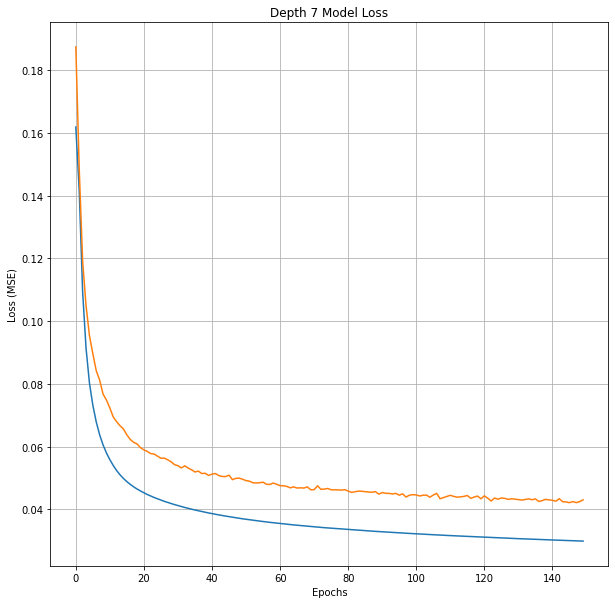

In [20]:
# Make a quick epoch vs. loss plot
plt.figure(figsize=(10,10))
plt.grid()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Depth 7 Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')

Text(0, 0.5, 'Accuracy')

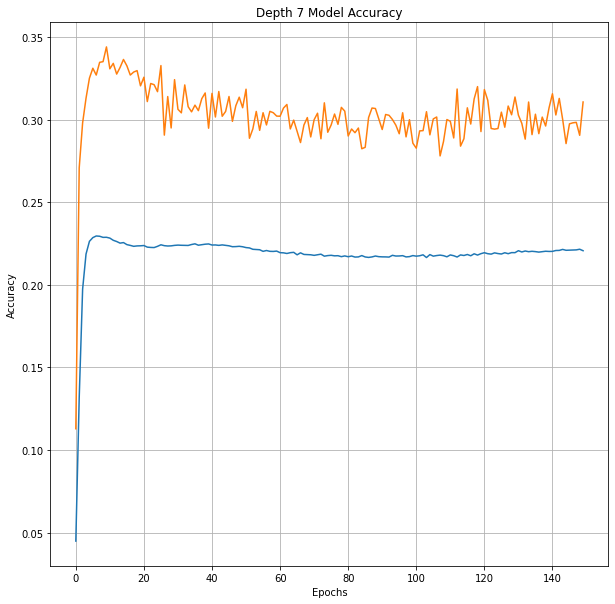

In [21]:
# Make a quick epoch vs. accuracy plot
plt.figure(figsize=(10,10))
plt.grid()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Depth 7 Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

In [28]:
""""""
# predict
from sklearn.metrics import precision_score,accuracy_score, f1_score, recall_score, hamming_loss

start = time.time()
predictions_d7 = model_d7.predict(x_test_d7.values)
end = time.time()
print("Time: " + str(end - start))

pred=predictions_d7.copy()


thresholds=[0.1, 0.2, 0.3, .4, .5, .6, .7, .8, .9]
for val in thresholds:
    pred=predictions_d7.copy()

  
    pred[pred>=val]=1
    pred[pred<val]=0
    
  
    precision = precision_score(Y_test_d7, pred, average='micro')
    recall = recall_score(Y_test_d7, pred, average='micro')
    f1 = f1_score(Y_test_d7, pred, average='micro')
   
    print("Micro-average quality numbers")
    print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))
    print("Accuracy = ",accuracy_score(Y_test_d7, pred))
    print("Accuracy = ",partial_accuracy(Y_test_d7, pred))
    print("\n")

ValueError: in user code:

    C:\Users\Bensom2\miniconda3\envs\my_qiskit\lib\site-packages\tensorflow\python\keras\engine\training.py:1569 predict_function  *
        return step_function(self, iterator)
    C:\Users\Bensom2\miniconda3\envs\my_qiskit\lib\site-packages\tensorflow\python\keras\engine\training.py:1559 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\Bensom2\miniconda3\envs\my_qiskit\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1285 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\Bensom2\miniconda3\envs\my_qiskit\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2833 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\Bensom2\miniconda3\envs\my_qiskit\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3608 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\Bensom2\miniconda3\envs\my_qiskit\lib\site-packages\tensorflow\python\keras\engine\training.py:1552 run_step  **
        outputs = model.predict_step(data)
    C:\Users\Bensom2\miniconda3\envs\my_qiskit\lib\site-packages\tensorflow\python\keras\engine\training.py:1525 predict_step
        return self(x, training=False)
    C:\Users\Bensom2\miniconda3\envs\my_qiskit\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:1013 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    C:\Users\Bensom2\miniconda3\envs\my_qiskit\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:251 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer sequential_13 is incompatible with the layer: expected axis -1 of input shape to have value 47 but received input with shape (32, 2)


In [29]:
"""
predictions_d7 = model_d7.predict(x_test_d7.values)
pred=predictions_d7.copy()

n_classes = 99

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test_d7[:, i], pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(Y_test_d7.ravel(), pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()"""

'\npredictions_d7 = model_d7.predict(x_test_d7.values)\npred=predictions_d7.copy()\n\nn_classes = 99\n\nfpr = dict()\ntpr = dict()\nroc_auc = dict()\nfor i in range(n_classes):\n    fpr[i], tpr[i], _ = roc_curve(Y_test_d7[:, i], pred[:, i])\n    roc_auc[i] = auc(fpr[i], tpr[i])\n\nfpr["micro"], tpr["micro"], _ = roc_curve(Y_test_d7.ravel(), pred.ravel())\nroc_auc["micro"] = auc(fpr["micro"], tpr["micro"])\n    \n# Plot of a ROC curve for a specific class\nfor i in range(n_classes):\n    plt.figure()\n    plt.plot(fpr[i], tpr[i], label=\'ROC curve (area = %0.2f)\' % roc_auc[i])\n    plt.plot([0, 1], [0, 1], \'k--\')\n    plt.xlim([0.0, 1.0])\n    plt.ylim([0.0, 1.05])\n    plt.xlabel(\'False Positive Rate\')\n    plt.ylabel(\'True Positive Rate\')\n    plt.title(\'Receiver operating characteristic example\')\n    plt.legend(loc="lower right")\n    plt.show()'

In [30]:
"""
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)

for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()"""

'\n# First aggregate all false positive rates\nall_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))\n\n# Then interpolate all ROC curves at this points\nmean_tpr = np.zeros_like(all_fpr)\n\nfor i in range(n_classes):\n    mean_tpr += interp(all_fpr, fpr[i], tpr[i])\n\n# Finally average it and compute AUC\nmean_tpr /= n_classes\n\nfpr["macro"] = all_fpr\ntpr["macro"] = mean_tpr\nroc_auc["macro"] = auc(fpr["macro"], tpr["macro"])\n\n# Plot all ROC curves\nplt.figure()\nplt.plot(fpr["micro"], tpr["micro"],\n         label=\'micro-average ROC curve (area = {0:0.2f})\'\n               \'\'.format(roc_auc["micro"]),\n         color=\'deeppink\', linestyle=\':\', linewidth=4)\n\nplt.plot([0, 1], [0, 1], \'k--\', lw=2)\nplt.xlim([0.0, 1.0])\nplt.ylim([0.0, 1.05])\nplt.xlabel(\'False Positive Rate\')\nplt.ylabel(\'True Positive Rate\')\nplt.title(\'Some extension of Receiver operating characteristic to multi-class\')\nplt.legend(loc="lower right")\nplt.show()'

In [31]:
"""
x_train_d3.to_csv("x_train_d3_01.csv")
x_test_d3.to_csv("x_test_d3_01.csv")
pd.DataFrame(Y_train_d3).to_csv("Y_train_d3_01.csv")
pd.DataFrame(Y_test_d3).to_csv("Y_test_d3_01.csv")

x_train_d5.to_csv("x_train_d5_01.csv")
x_test_d5.to_csv("x_test_d5_01.csv")
pd.DataFrame(Y_train_d5).to_csv("Y_train_d5_01.csv")
pd.DataFrame(Y_test_d5).to_csv("Y_test_d5_01.csv")

x_train_d7.to_csv("x_train_d7_01.csv")
x_test_d7.to_csv("x_test_d7_01.csv")
pd.DataFrame(Y_train_d7).to_csv("Y_train_d7_01.csv")
pd.DataFrame(Y_test_d7).to_csv("Y_test_d7_01.csv")"""

'\nx_train_d3.to_csv("x_train_d3_01.csv")\nx_test_d3.to_csv("x_test_d3_01.csv")\npd.DataFrame(Y_train_d3).to_csv("Y_train_d3_01.csv")\npd.DataFrame(Y_test_d3).to_csv("Y_test_d3_01.csv")\n\nx_train_d5.to_csv("x_train_d5_01.csv")\nx_test_d5.to_csv("x_test_d5_01.csv")\npd.DataFrame(Y_train_d5).to_csv("Y_train_d5_01.csv")\npd.DataFrame(Y_test_d5).to_csv("Y_test_d5_01.csv")\n\nx_train_d7.to_csv("x_train_d7_01.csv")\nx_test_d7.to_csv("x_test_d7_01.csv")\npd.DataFrame(Y_train_d7).to_csv("Y_train_d7_01.csv")\npd.DataFrame(Y_test_d7).to_csv("Y_test_d7_01.csv")'

In [35]:
"""
model_d7.save("model_d7_01.h5")
model_d5.save("model_d5_01.h5")
model.save("model_d3_01.h5")"""

'\nmodel_d7.save("model_d7_01.h5")\nmodel_d5.save("model_d5_01.h5")\nmodel.save("model_d3_01.h5")'